In [2]:
# Importando librerias necesarias
from datasets import load_dataset
from datasets import load_metric
from transformers import pipeline
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import sentencepiece
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import label_binarize
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu
from sacrebleu import corpus_bleu as sacre_corpus_bleu
from rouge_score import rouge_scorer
from scipy.stats import pearsonr


C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Summarization

## Pruebas con el t5

### 1ra prueba con t5-small

In [3]:
# Descarga del dataset a utilizar 
tldr_17_dataset = load_dataset("webis/tldr-17",
cache_dir= "local-datasets", trust_remote_code=True                
)
tldr_17_dataset 

DatasetDict({
    train: Dataset({
        features: ['author', 'body', 'normalizedBody', 'subreddit', 'subreddit_id', 'id', 'content', 'summary'],
        num_rows: 3848330
    })
})

In [4]:
tldr_17_sample = tldr_17_dataset["train"].select(range(10))
display(tldr_17_sample.to_pandas()) 

,author,body,normalizedBody,subreddit,subreddit_id,id,content,summary
0,raysofdarkmatter,I think it should be fixed on either UTC stand...,I think it should be fixed on either UTC stand...,math,t5_2qh0n,c69al3r,I think it should be fixed on either UTC stand...,Shifting seasonal time is no longer worth it.
1,Stork13,Art is about the hardest thing to categorize i...,Art is about the hardest thing to categorize i...,funny,t5_2qh33,c6a9nxd,Art is about the hardest thing to categorize i...,Personal opinions 'n shit.
2,Cloud_dreamer,Ask me what I think about the Wall Street Jour...,Ask me what I think about the Wall Street Jour...,Borderlands,t5_2r8cd,c6acx4l,Ask me what I think about the Wall Street Jour...,insults and slack ass insight. \n Wall Street ...
3,NightlyReaper,"In Mechwarrior Online, I have begun to use a m...","In Mechwarrior Online, I have begun to use a m...",gamingpc,t5_2sq2y,c8onqew,"In Mechwarrior Online, I have begun to use a m...","Yes, Joysticks in modern games have apparently..."
4,NuffZetPand0ra,"You are talking about the Charsi imbue, right?...","You are talking about the Charsi imbue, right?...",Diablo,t5_2qore,c6acxvc,"You are talking about the Charsi imbue, right?...",Class only items dropped from high-lvl monsters.
5,beatlecreedcabaret,All but one of my nails were in the ballpark o...,All but one of my nails were in the ballpark o...,RedditLaqueristas,t5_2se5q,c6ahuc4,All but one of my nails were in the ballpark o...,OPI Nail Envy!
6,nobodysdiary,I could give a shit about turn by turn directi...,I could give a shit about turn by turn directi...,apple,t5_2qh1f,c6aggux,I could give a shit about turn by turn directi...,I don't drive like most people in major citi...
7,chrom_ed,"So you're saying ""try it, I might not mind los...","So you're saying ""try it, I might not mind los...",apple,t5_2qh1f,c6agxtv,"So you're saying ""try it, I might not mind los...",you don't seem to understand what's going on h...
8,gadzookfilms,I love this idea and most definitely want to h...,I love this idea and most definitely want to h...,RedditFilmsProduction,t5_2v33h,c6asb7p,I love this idea and most definitely want to h...,"How we make money? How we involve everyone, yo?"
9,iamacannibal,Theres an entire small town under the lake by ...,Theres an entire small town under the lake by ...,AbandonedPorn,t5_2sh6t,c6aveyw,Theres an entire small town under the lake by ...,I'll try and get some similar shots from lake ...


In [4]:
# Modelo y parametros
summarizer1 = pipeline(
    task="summarization",
    model="t5-small",
    min_length=20,
    max_length=45,
    truncation=True,
    model_kwargs={"cache_dir":"local-pipelines"},
)

In [5]:
# Se gerneran muestras de resumenes
predictions = [summarizer1(content)[0]['summary_text'] for content in tldr_17_sample["content"]]

# Guarda los resumenes generados y los
references = tldr_17_sample["summary"]

In [6]:
# Seleccionar una muestra del dataset
tldr_17_sample = tldr_17_dataset["train"].select(range(10))

In [7]:
# Acceder a la columna 'body' y utilizar la función summarizer
body_text = tldr_17_sample["body"][0] 
summary = summarizer1(body_text)
print(summary)

[{'summary_text': "changing timescales add a lot of complexity to the implementation of timekeeping systems . it's more beneficial to spend a small amount on energy for lighting, and save the irritation to humans ."}]


In [8]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][0])

I think it should be fixed on either UTC standard or UTC+1 year around, with the current zone offsets.

Moving timescales add a lot of complexity to the implementation of timekeeping systems and have [dubious value]( 

I think seasonal shifting time made sense in the pre-electric past, when timekeeping was more flexible and artificial light was inefficient and often dangerous. 

Now we have machines that work easily with simple timekeeping rules, and it's more beneficial to spend a small amount on energy for lighting, and save the larger cost of engineering things to work with the complex timekeeping rules, as well as saving the irritation to humans.

Lighting has gotten much more efficient over time; we can squeeze out a lot more photons per unit of energy from a 2012 CFL or LED than a candle could in 1780, or a lightbulb could in 1950. 

There's a lot of room for improvement in how we use lights as well; as lighting control gets more intelligent, there will be a lot of savings from n

In [9]:
summary = summarizer1(tldr_17_sample["body"][0])
print(summary)

[{'summary_text': "changing timescales add a lot of complexity to the implementation of timekeeping systems . it's more beneficial to spend a small amount on energy for lighting, and save the irritation to humans ."}]


In [10]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][1])

Art is about the hardest thing to categorize in terms of good and bad. To consider one work or artist as dominate over another comes down to personal opinion. Sure some things maybe blatantly better than other works, but it ultimately lies with the individual. I personally enjoy the work of "street artists" (using quotations not to be sarcastic, but mainly because this is in a different category than graffiti and since my background is not in art I don't know what the "proper" term is , if there is one), but I do see where you are coming from. CLET tends to use the same images continuously (to a point where one could say "Is this it?") as do most street artists (I do think this term is thrown around a lot more than it should be, I agree with you there) and it can be annoying.

tl;dr: Personal opinions 'n shit.


In [11]:
summary = summarizer1(tldr_17_sample["body"][1])
print(summary)

[{'summary_text': 'art is about the hardest thing to categorize in terms of good and bad . to consider one work or artist as dominate over another comes down to personal opinion . "street artists" tends to use the'}]


In [12]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][2])

Ask me what I think about the Wall Street Journal and I'll tell you about it's bland, monumental, walls of text.

 This isn't the deeply engrossing reading material that the bubblegum popping, paparazzi loving celebrities read in the daily publications of The L.A. Times. 

It’s apparent that Wall Street journal is going after that greed driven, white GOP, 50-90-or-so demographic, with its over-the-top use of big words nobody really gives a shit about (eg. “gratuitous....magilla ”),  TL;DR insults and slack ass insight.

Wall Street Journal misses on enough counts that not only did i yawn with boredom, i fell asleep trying to read through this crap. 

It may be the paper for you, but if your in the the market for a new read, i'd at least counsel you on reading the Washington Post instead, due out on stands anytime, or the Globe, which is slated for a weekly release.


In [13]:
summary = summarizer1(tldr_17_sample["body"][8])
print(summary)

[{'summary_text': "reddit's strength is in the hive, for better or worse, and I'd hate to relegate decisions to some of us who happen to live in LA . TL;DR"}]


In [14]:
summary = summarizer1(tldr_17_sample["body"][2])
print(summary)

[{'summary_text': "the l.a. Times is slated for a weekly release . it's not the engrossing reading material that the bubblegum popping paparazzi loving celebrities read ."}]


In [15]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][3])

In Mechwarrior Online, I have begun to use a mouse for the "turret" aspect of the torso twist/tilt and a Logitech G13 for other controls (  The G-13 has a little thumbstick that works well for WASD functions and has a little keyboard to cover all the other (limited) controls required for MWO.  For modern games, I guess that's as close to HOTAS as they want you to get.  For a better solution, I think that with a joystick emulating mouse inputs it would be passable, but as you said:  It's presently a sad day and you have to be able to edit XML files to modify joystick input triggers and it starts becoming an occupation rather than a gaming hobby.  In Mechwarrior 2, 3, &amp; 4 I use the Steel Battalion controller and it is freaking awesome to have the three axes of torso twist, tilt, walking direction, plus a real throttle, plus real hat switches for views, plus pedals for extra speed, stopping power and jumpjet control.  Not to mention the 32 other buttons and the flip cover over the eje

In [16]:
summary = summarizer1(tldr_17_sample["body"][3])
print(summary)

[{'summary_text': 'in Mechwarrior Online, I have begun to use a mouse for the "turret" aspect of the torso twist/tilt . Logitech G13 has a'}]


In [17]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][4])

You are talking about the Charsi imbue, right? Or a cube upgrade?
If we are talking Charsi imbue, you can only imbue WHITE items. This includes superior, but they will not neccesarily be superior after imbuing (they get random base-modifications). Bloodfist and Gorefoot are both uniques (gold), and therefore not eligible for imbuing.
When you imbue, the item level matters (the item level is hidden). The item is the same level as the monster who dropped it. That means, that the higher level the monster who dropped it, the more stats is available on that item. It is important to note that an item doesn't neccesarily use all it's stat potential. This means that the same item dropped in a1 and a2 can has the possibility of some very different outcomes.
After the imbue, the item can be as good as if the monster itself had dropped a rare (yellow) item. Imbued weapons will always turn out as rare items.
To answer your question, you should just progress like you are now, fighting the hardest m

In [18]:
summary = summarizer1(tldr_17_sample["body"][4])
print(summary)

[{'summary_text': 'you can only imbue WHITE items with base bonuses . this includes superior, but they will not neccesarily be superior after imbuing . the item level matters (the item level is'}]


In [19]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][5])

All but one of my nails were in the ballpark of 1 1/8" - 1 1/2" long when my ring finger nail broke to the quick on Monday! It was the second break on the same hand in about a month, so I finally had to get compulsive and make all the nails the same length! I probably cut off more than half the length of the free edge. 

As a side note, I used to be a **serious** nail biter all through my childhood and high school. I have had occasional relapses in my adulthood as well, but the point I'm trying to make is that my nail beds are *really* short, and I think my nails that short show about 1/8" of my fingertips and look so sad! 

TL;DR: OPI Nail Envy!


In [20]:
summary = summarizer1(tldr_17_sample["body"][5])
print(summary)

[{'summary_text': 'all but one of my nails were in the ballpark of 1 1/8" - 1 1/2" long when my ring finger nail broke to the quick on Monday . it was the second break on the same hand'}]


In [21]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][6])

I could give a shit about turn by turn directions because I never drive and the new maps doesn't have ANY public transportation directions which is just complete bullshit -- especially for a company that is supposedly "green" conscious.

I know Apple and others have said that you can just get a 3rd party app, but to be honest I haven't found one for NYC Metro area that is as fast and complete as iOS5 Maps. It has integrated bus routes/schedules and train schedules and as someone else pointed out in another thread about this subject, you will need another 3rd party app if you go to a city other than your own, instead of easily being able to get directions as you travel. 

I would also argue that since NYC of all places has a pretty shitty selection of 3rd party options, that the available options in other smaller major cities would be significantly shittier.

**TL;DR** - I don't drive like *most* people in major cities, and need public transit directions integrated in iOS6 Maps. 


In [22]:
summary = summarizer1(tldr_17_sample["body"][6])
print(summary)

[{'summary_text': 'apple and others have said that you can just get a 3rd party app for NYC metro area . it has integrated bus routes/schedules and train schedules . if you go to '}]


In [23]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][7])

So you're saying "try it, I might not mind losing access to directions that follow my only available mode of transportation (public)"? This isn't a it might be ok but some people don't like it issue like Siri not listening to you *well*. This is removing an entire function that I use all the time. It's not worth it and I won't be upgrading. Especially since they still haven't provided a feature that lets you roll anything back to a previous version (which just boggles my mind). If have to roll everything back using a backup of it turned out that, yes, I really can't find my way through the maze of subways, busses, and trains that make up the greater NY area with a combination of 3D flyovers, luck, and *magic*. 

Tl;dr you don't seem to understand what's going on here. 


In [24]:
summary = summarizer1(tldr_17_sample["body"][7])
print(summary)

[{'summary_text': "some people don't like it issue like Siri not listening to you *well* . this is removing an entire function that I use all the time . it's not worth it and I won'"}]


In [25]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][8])

I love this idea and most definitely want to help. I have a few concerns though. My primary concern is that of financing. Making movies isn't free as we all know. It's fine to work on one or two volunteer projects for fun and to build interest and community but somewhere down the line it must be made sustainable. Otherwise the turnover rate of artists skyrockets. 

My secondary concern is keeping this as open, transparent, and democratic as possible. Reddit's strength is in the hive, for better or worse, and I'd hate to relegate decisions to a few of us who happen to live in LA. From the get-go this needs to be a global initiative. So yeah, getting out of that SoCal bubble is key.

TL;DR - How we make money? How we involve everyone, yo?


In [26]:
summary = summarizer1(tldr_17_sample["body"][8])
print(summary)

[{'summary_text': "reddit's strength is in the hive, for better or worse, and I'd hate to relegate decisions to some of us who happen to live in LA . TL;DR"}]


In [27]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][9])

Theres an entire small town under the lake by my house. I'll try and get up there soon to take pictures. the lake should be pretty empty right now. Usually is at the end of summer and before rainy season. It's actually pretty close to Shaver lake. Lake Kaweah in CA. I don't remember the story well but they either made the lake or made it bigger and the town had to be moved. didnt take down the buildings and once in a while you can see them sticking up a bit out of the water. I think the area use to just be a river. a decent part of the Central Valley use to be a lake because of all of the rivers flowing in. Shaver might be from this too. blocking off the rivers to dry up the valley. Not sure though. 
 this is what it use to be. Tulare Lake. Biggest lake on the west side of the Mississippi river. Now the valley is dried up but has some of the best soil for crops in the world. 

TL;DR: I'll try and get some similar shots from lake Kaweah next time I'm up there because there is an entire 

In [28]:
summary = summarizer1(tldr_17_sample["body"][9])
print(summary)

[{'summary_text': 'the lake should be pretty empty right now . a decent part of the Central Valley use to be a lake because of all of the rivers flowing in .'}]


In [29]:
predictions_t5_small = []

for i in range(10):
    # Aquí se realiza cada predicción y se guarda en `summary`
    summary = summarizer1(tldr_17_sample["content"][i])
    
    # Agregar `summary` a `predictions_t5_small`
    predictions_t5_small.append(summary)

### 2da prueba con t5-large

In [30]:
summarizer2 = pipeline(
    task="summarization",
    model="t5-large",
    min_length=20,
    max_length=80,
    truncation=True,
    model_kwargs={"cache_dir":"local-pipelines"},
)

In [31]:
# Generar resúmenes para la muestra
predictions = [summarizer2(content)[0]['summary_text'] for content in tldr_17_sample["body"]]

# Guardar los resúmenes generados y los resúmenes de referencia
references = tldr_17_sample["summary"]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [32]:
# Seleccionar una muestra del dataset
tldr_17_sample = tldr_17_dataset["train"].select(range(10))

In [33]:
# Acceder a la columna 'body' y utilizar la función summarizer
body_text = tldr_17_sample["body"][0] 
summary = summarizer2(body_text)
print(summary)

[{'summary_text': "shifting timescales add a lot of complexity to the implementation of timekeeping systems . shifting seasonal time made sense in the pre-electric past, when timekeeping was more flexible . it's more beneficial to spend a small amount on energy for lighting, and save the larger cost of engineering things to work with complex timekeeping rules ."}]


In [34]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][0])

I think it should be fixed on either UTC standard or UTC+1 year around, with the current zone offsets.

Moving timescales add a lot of complexity to the implementation of timekeeping systems and have [dubious value]( 

I think seasonal shifting time made sense in the pre-electric past, when timekeeping was more flexible and artificial light was inefficient and often dangerous. 

Now we have machines that work easily with simple timekeeping rules, and it's more beneficial to spend a small amount on energy for lighting, and save the larger cost of engineering things to work with the complex timekeeping rules, as well as saving the irritation to humans.

Lighting has gotten much more efficient over time; we can squeeze out a lot more photons per unit of energy from a 2012 CFL or LED than a candle could in 1780, or a lightbulb could in 1950. 

There's a lot of room for improvement in how we use lights as well; as lighting control gets more intelligent, there will be a lot of savings from n

In [35]:
summary = summarizer2(tldr_17_sample["body"][0])
print(summary)

[{'summary_text': "shifting timescales add a lot of complexity to the implementation of timekeeping systems . shifting seasonal time made sense in the pre-electric past, when timekeeping was more flexible . it's more beneficial to spend a small amount on energy for lighting, and save the larger cost of engineering things to work with complex timekeeping rules ."}]


In [36]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][1])

Art is about the hardest thing to categorize in terms of good and bad. To consider one work or artist as dominate over another comes down to personal opinion. Sure some things maybe blatantly better than other works, but it ultimately lies with the individual. I personally enjoy the work of "street artists" (using quotations not to be sarcastic, but mainly because this is in a different category than graffiti and since my background is not in art I don't know what the "proper" term is , if there is one), but I do see where you are coming from. CLET tends to use the same images continuously (to a point where one could say "Is this it?") as do most street artists (I do think this term is thrown around a lot more than it should be, I agree with you there) and it can be annoying.

tl;dr: Personal opinions 'n shit.


In [37]:
summary = summarizer2(tldr_17_sample["body"][1])
print(summary)

[{'summary_text': 'art is about the hardest thing to categorize in terms of good and bad . to consider one work or artist as dominate over another comes down to personal opinion . i personally enjoy the work of "street artists" but i do see where you are coming from .'}]


In [38]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][2])

Ask me what I think about the Wall Street Journal and I'll tell you about it's bland, monumental, walls of text.

 This isn't the deeply engrossing reading material that the bubblegum popping, paparazzi loving celebrities read in the daily publications of The L.A. Times. 

It’s apparent that Wall Street journal is going after that greed driven, white GOP, 50-90-or-so demographic, with its over-the-top use of big words nobody really gives a shit about (eg. “gratuitous....magilla ”),  TL;DR insults and slack ass insight.

Wall Street Journal misses on enough counts that not only did i yawn with boredom, i fell asleep trying to read through this crap. 

It may be the paper for you, but if your in the the market for a new read, i'd at least counsel you on reading the Washington Post instead, due out on stands anytime, or the Globe, which is slated for a weekly release.


In [39]:
summary = summarizer2(tldr_17_sample["body"][2])
print(summary)

[{'summary_text': "the wall street journal is going after that greed driven, white GOP, 50-90-or-so demographic with its over-the-top use of big words nobody really gives a shit about . if your the market for a new read, i'd at least counsel you on reading the Washington post instead, due out on stands anytime ."}]


In [40]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][3])

In Mechwarrior Online, I have begun to use a mouse for the "turret" aspect of the torso twist/tilt and a Logitech G13 for other controls (  The G-13 has a little thumbstick that works well for WASD functions and has a little keyboard to cover all the other (limited) controls required for MWO.  For modern games, I guess that's as close to HOTAS as they want you to get.  For a better solution, I think that with a joystick emulating mouse inputs it would be passable, but as you said:  It's presently a sad day and you have to be able to edit XML files to modify joystick input triggers and it starts becoming an occupation rather than a gaming hobby.  In Mechwarrior 2, 3, &amp; 4 I use the Steel Battalion controller and it is freaking awesome to have the three axes of torso twist, tilt, walking direction, plus a real throttle, plus real hat switches for views, plus pedals for extra speed, stopping power and jumpjet control.  Not to mention the 32 other buttons and the flip cover over the eje

In [41]:
summary = summarizer2(tldr_17_sample["body"][3])
print(summary)

[{'summary_text': 'joysticks in modern games have apparently become passe unless you are playing a flight sim and that sucks . in Mechwarrior 2, 3, &amp; 4 i use the Steel Battalion controller and it is freaking awesome to have the three axes of torso twist, tilt, walking direction, plus a real throttle'}]


In [42]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][4])

You are talking about the Charsi imbue, right? Or a cube upgrade?
If we are talking Charsi imbue, you can only imbue WHITE items. This includes superior, but they will not neccesarily be superior after imbuing (they get random base-modifications). Bloodfist and Gorefoot are both uniques (gold), and therefore not eligible for imbuing.
When you imbue, the item level matters (the item level is hidden). The item is the same level as the monster who dropped it. That means, that the higher level the monster who dropped it, the more stats is available on that item. It is important to note that an item doesn't neccesarily use all it's stat potential. This means that the same item dropped in a1 and a2 can has the possibility of some very different outcomes.
After the imbue, the item can be as good as if the monster itself had dropped a rare (yellow) item. Imbued weapons will always turn out as rare items.
To answer your question, you should just progress like you are now, fighting the hardest m

In [43]:
summary = summarizer2(tldr_17_sample["body"][4])
print(summary)

[{'summary_text': 'when you imbue, the item level matters (the item level is hidden) the higher level the monster who dropped it, the more stats is available on that item . class specifiq items has a better chance to give +skills to your class .'}]


In [44]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][5])

All but one of my nails were in the ballpark of 1 1/8" - 1 1/2" long when my ring finger nail broke to the quick on Monday! It was the second break on the same hand in about a month, so I finally had to get compulsive and make all the nails the same length! I probably cut off more than half the length of the free edge. 

As a side note, I used to be a **serious** nail biter all through my childhood and high school. I have had occasional relapses in my adulthood as well, but the point I'm trying to make is that my nail beds are *really* short, and I think my nails that short show about 1/8" of my fingertips and look so sad! 

TL;DR: OPI Nail Envy!


In [45]:
summary = summarizer2(tldr_17_sample["body"][5])
print(summary)

[{'summary_text': 'all but one of my nails were in the ballpark of 1 1/8" - 1 1/2" long . it was the second break on the same hand in about a month . i used to be a **serious** nail biter all through my childhood .'}]


In [46]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][6])

I could give a shit about turn by turn directions because I never drive and the new maps doesn't have ANY public transportation directions which is just complete bullshit -- especially for a company that is supposedly "green" conscious.

I know Apple and others have said that you can just get a 3rd party app, but to be honest I haven't found one for NYC Metro area that is as fast and complete as iOS5 Maps. It has integrated bus routes/schedules and train schedules and as someone else pointed out in another thread about this subject, you will need another 3rd party app if you go to a city other than your own, instead of easily being able to get directions as you travel. 

I would also argue that since NYC of all places has a pretty shitty selection of 3rd party options, that the available options in other smaller major cities would be significantly shittier.

**TL;DR** - I don't drive like *most* people in major cities, and need public transit directions integrated in iOS6 Maps. 


In [47]:
summary = summarizer2(tldr_17_sample["body"][6])
print(summary)

[{'summary_text': "the new maps doesn't have ANY public transportation directions which is just complete bullshit . I don't drive like *most* people in major cities, and need public transit directions integrated in iOS6 Maps."}]


In [48]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][7])

So you're saying "try it, I might not mind losing access to directions that follow my only available mode of transportation (public)"? This isn't a it might be ok but some people don't like it issue like Siri not listening to you *well*. This is removing an entire function that I use all the time. It's not worth it and I won't be upgrading. Especially since they still haven't provided a feature that lets you roll anything back to a previous version (which just boggles my mind). If have to roll everything back using a backup of it turned out that, yes, I really can't find my way through the maze of subways, busses, and trains that make up the greater NY area with a combination of 3D flyovers, luck, and *magic*. 

Tl;dr you don't seem to understand what's going on here. 


In [49]:
summary = summarizer2(tldr_17_sample["body"][7])
print(summary)

[{'summary_text': "this isn't a it might be ok but some people don't like it issue like Siri not listening to you *well* this is removing an entire function that i use all the time . if have to roll everything back using a backup of it turned out that, yes, I really can't find my way through the maze of subway"}]


In [50]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][8])

I love this idea and most definitely want to help. I have a few concerns though. My primary concern is that of financing. Making movies isn't free as we all know. It's fine to work on one or two volunteer projects for fun and to build interest and community but somewhere down the line it must be made sustainable. Otherwise the turnover rate of artists skyrockets. 

My secondary concern is keeping this as open, transparent, and democratic as possible. Reddit's strength is in the hive, for better or worse, and I'd hate to relegate decisions to a few of us who happen to live in LA. From the get-go this needs to be a global initiative. So yeah, getting out of that SoCal bubble is key.

TL;DR - How we make money? How we involve everyone, yo?


In [51]:
summary = summarizer2(tldr_17_sample["body"][8])
print(summary)

[{'summary_text': 'reddit is a great place to start a filmmaking initiative . i have a few concerns though: how we make money? how we involve everyone, yo?'}]


In [52]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][9])

Theres an entire small town under the lake by my house. I'll try and get up there soon to take pictures. the lake should be pretty empty right now. Usually is at the end of summer and before rainy season. It's actually pretty close to Shaver lake. Lake Kaweah in CA. I don't remember the story well but they either made the lake or made it bigger and the town had to be moved. didnt take down the buildings and once in a while you can see them sticking up a bit out of the water. I think the area use to just be a river. a decent part of the Central Valley use to be a lake because of all of the rivers flowing in. Shaver might be from this too. blocking off the rivers to dry up the valley. Not sure though. 
 this is what it use to be. Tulare Lake. Biggest lake on the west side of the Mississippi river. Now the valley is dried up but has some of the best soil for crops in the world. 

TL;DR: I'll try and get some similar shots from lake Kaweah next time I'm up there because there is an entire 

In [53]:
summary = summarizer2(tldr_17_sample["body"][9])
print(summary)

[{'summary_text': "theres an entire small town under the lake by my house. i'll try and get up there soon to take pictures . it's actually pretty close to Shaver lake ."}]


In [54]:
predictions_t5_large = []

for i in range(10):
    # Aquí se realiza cada predicción y se guarda en `summary`
    summary = summarizer2(tldr_17_sample["body"][i])
    
    # Agregar `summary` a `predictions_t5_large`
    predictions_t5_large.append(summary)

### Analisis con ROUGUE del t5-large y el t5-small

##### Metricas de ROUGUE

In [55]:
# Cargar la métrica ROUGE
rouge_metric = load_metric("rouge", trust_remote_code=True)

# Definir predicciones y referencias para t5-small 
predictions_t5_small  
references 

# Calcular ROUGE para t5-small
results_t5_small = rouge_metric.compute(predictions=predictions_t5_small, references=references)

# Definir predicciones y referencias para t5-large 
predictions_t5_large  
references 

# Calcular ROUGE para t5-large
results_t5_large = rouge_metric.compute(predictions=predictions_t5_large, references=references)

# Imprimir los resultados de ROUGE para cada modelo
print("Resultados ROUGE para t5-small:")
print(results_t5_small)
print("\nResultados ROUGE para t5-large:")
print(results_t5_large)

C:\Users\micha\AppData\Local\Temp\ipykernel_11348\4086763023.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric("rouge", trust_remote_code=True)


Resultados ROUGE para t5-small:
{'rouge1': AggregateScore(low=Score(precision=0.04055620023563573, recall=0.1267948465810308, fmeasure=0.05896072918872495), mid=Score(precision=0.08334318831472531, recall=0.18650660229607596, fmeasure=0.09602311023369496), high=Score(precision=0.14323605109575221, recall=0.24636139578573787, fmeasure=0.13231740978356182)), 'rouge2': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.006060606060606061, recall=0.0027397260273972603, fmeasure=0.0037735849056603774), high=Score(precision=0.01818181818181818, recall=0.00821917808219178, fmeasure=0.011320754716981133)), 'rougeL': AggregateScore(low=Score(precision=0.034480017905421136, recall=0.10297424667490458, fmeasure=0.05051270855871463), mid=Score(precision=0.06374090062420235, recall=0.15912718939034728, fmeasure=0.07513785684640699), high=Score(precision=0.10188350542655569, recall=0.22118236957052745, fmeasure=0.09699961896800906)), 'rougeLsum': AggregateScore(

In [56]:
# Cargar la métrica ROUGE
rouge_metric = load_metric("rouge")

# Calcular ROUGE para t5-small
results_t5_small = rouge_metric.compute(predictions=predictions_t5_small, references=references)

# Calcular ROUGE para t5-large
results_t5_large = rouge_metric.compute(predictions=predictions_t5_large, references=references)


##### Metricas de ROUGUE por longitud de texto

In [57]:
# Comprobar si hay GPU disponible
device = 0 if torch.cuda.is_available() else -1

# Cargar los modelos T5-small y T5-large
summarizer_t5small = pipeline("summarization", model="t5-small", device=device)
summarizer_t5large = pipeline("summarization", model="t5-large", device=device)

# Cargar el conjunto de datos de prueba
dataset = load_dataset("cnn_dailymail", "3.0.0", split="test[:10]")  # Ejemplo con las primeras 10 muestras
texts = dataset["article"]
references = dataset["highlights"]

# Función para acortar textos largos
def truncate_texts(texts, max_length=512):
    truncated_texts = [" ".join(text.split()[:max_length]) for text in texts]
    return truncated_texts

# Truncar textos largos
texts = truncate_texts(texts)

# Función para generar resúmenes en lotes
def generate_summaries(summarizer, texts, batch_size=2, max_length=200, min_length=50):
    summaries = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        batch_summaries = summarizer(batch_texts, max_length=max_length, min_length=min_length)
        summaries.extend([summary['summary_text'] for summary in batch_summaries])
    return summaries

# Generar predicciones para T5-small y T5-large en lotes
predictions_t5_small = generate_summaries(summarizer_t5small, texts)
predictions_t5_large = generate_summaries(summarizer_t5large, texts)

# Crear DataFrames para cada modelo
data_t5_small = pd.DataFrame({'predicted_label': predictions_t5_small, 'true_label': references})
data_t5_large = pd.DataFrame({'predicted_label': predictions_t5_large, 'true_label': references})

# Función para agrupar textos por longitud de texto
def group_by_text_length(data, bins):
    data['predicted_length'] = data['predicted_label'].apply(lambda x: len(x.split()))
    data['true_length'] = data['true_label'].apply(lambda x: len(x.split()))
    data['text_length'] = data[['predicted_length', 'true_length']].max(axis=1)
    data['text_length_bin'] = pd.cut(data['text_length'], bins=bins, right=False)
    return data

# Cargar la métrica ROUGE
rouge_metric = load_metric("rouge", trust_remote_code=True)

# Función para calcular ROUGE por longitud de texto
def calculate_rouge_by_length(data, rouge_metric):
    rouge_by_length = data.groupby('text_length_bin').apply(lambda x: rouge_metric.compute(predictions=x['predicted_label'], references=x['true_label']))
    return rouge_by_length

# Definir los bins para agrupar por longitud de texto
bins = [0, 100, 200, 300, 400, float('inf')]

# Agrupar por longitud de texto para T5-small y T5-large
joined_data_t5_small = group_by_text_length(data_t5_small, bins=bins)
joined_data_t5_large = group_by_text_length(data_t5_large, bins=bins)

# Calcular ROUGE por longitud de texto para T5-small y T5-large
rouge_by_length_t5_small = calculate_rouge_by_length(joined_data_t5_small, rouge_metric)
rouge_by_length_t5_large = calculate_rouge_by_length(joined_data_t5_large, rouge_metric)

# Función para imprimir los resultados de ROUGE por longitud de texto
def print_rouge_by_length(rouge_by_length):
    for length_bin, rouge_scores in rouge_by_length.items():
        print(f"\nROUGE scores for text length bin {length_bin}:")
        if 'rouge1' in rouge_scores:
            print(f"ROUGE-1: {rouge_scores['rouge1']}")
        if 'rouge2' in rouge_scores:
            print(f"ROUGE-2: {rouge_scores['rouge2']}")
        if 'rougeL' in rouge_scores:
            print(f"ROUGE-L: {rouge_scores['rougeL']}")
        if 'rougeLsum' in rouge_scores:
            print(f"ROUGE-Lsum: {rouge_scores['rougeLsum']}")

# Mostrar los resultados para T5-small
print("ROUGE scores for T5-small by text length:")
print_rouge_by_length(rouge_by_length_t5_small)

# Mostrar los resultados para T5-large
print("\nROUGE scores for T5-large by text length:")
print_rouge_by_length(rouge_by_length_t5_large)


Token indices sequence length is longer than the specified maximum sequence length for this model (708 > 512). Running this sequence through the model will result in indexing errors
Your max_length is set to 200, but your input_length is only 161. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)
Your max_length is set to 200, but your input_length is only 161. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)
C:\Users\micha\AppData\Local\Temp\ipykernel_11348\2093918757.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rouge_by_len

ROUGE scores for T5-small by text length:

ROUGE scores for text length bin [0.0, 100.0):
ROUGE-1: AggregateScore(low=Score(precision=0.2677812526620666, recall=0.3608082695208569, fmeasure=0.3065200048246404), mid=Score(precision=0.3602480691483139, recall=0.4323072936695228, fmeasure=0.3814353979826145), high=Score(precision=0.4599060657111147, recall=0.49508235355778824, fmeasure=0.4544751255384707))
ROUGE-2: AggregateScore(low=Score(precision=0.09239590038567026, recall=0.1278094033467561, fmeasure=0.10758078368881271), mid=Score(precision=0.14794780454428014, recall=0.18498246379016026, fmeasure=0.1592526956412183), high=Score(precision=0.2212514103693271, recall=0.23625012862024755, fmeasure=0.2158639876902553))
ROUGE-L: AggregateScore(low=Score(precision=0.18788090813715047, recall=0.24469376768795376, fmeasure=0.21639974890321254), mid=Score(precision=0.2382764646614096, recall=0.29321645426836584, fmeasure=0.25660061946376944), high=Score(precision=0.2968097360870463, recall=0

C:\Users\micha\AppData\Local\Temp\ipykernel_11348\2093918757.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rouge_by_length = data.groupby('text_length_bin').apply(lambda x: rouge_metric.compute(predictions=x['predicted_label'], references=x['true_label']))


##### Distribucion de puntuaciones

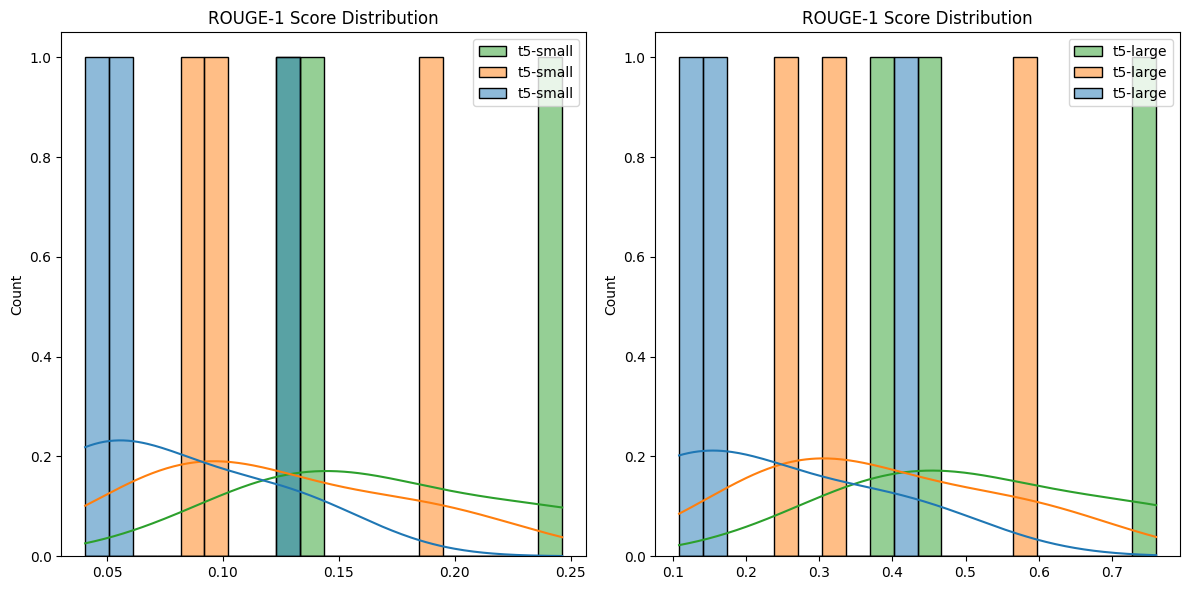

: 

In [58]:
# Visualizar la distribución de puntuaciones ROUGE
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(results_t5_small['rouge1'], bins=20, kde=True, color='blue', label='t5-small')
plt.title('ROUGE-1 Score Distribution')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(results_t5_large['rouge1'], bins=20, kde=True, color='orange', label='t5-large')
plt.title('ROUGE-1 Score Distribution')
plt.legend()

plt.tight_layout()
plt.show()

## Pruebas con el vit5

### 1ra prueba con vit5-large

In [5]:
summarizer3 = pipeline(
    task="summarization",
    model="VietAI/vit5-large-vietnews-summarization",
    min_length=20,
    max_length=100,
    truncation=True,
    model_kwargs={"cache_dir":"local-pipelines"},
)

In [6]:
# Generar resúmenes para la muestra
predictions = [summarizer3(content)[0]['summary_text'] for content in tldr_17_sample["body"]]

# Guardar los resúmenes generados y los resúmenes de referencia
references = tldr_17_sample["summary"]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [7]:
# Seleccionar una muestra del dataset
tldr_17_sample = tldr_17_dataset["train"].select(range(10))

In [8]:
# Acceder a la columna 'body' y utilizar la función summarizer
body_text = tldr_17_sample["body"][0] 
summary = summarizer3(body_text)
print(summary)

[{'summary_text': 'I think seasonal shifting time made sense in the pre-electric past , when timekeeping was more flexible and artificial light was inefficient and often dangerous .'}]


In [9]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][0])

I think it should be fixed on either UTC standard or UTC+1 year around, with the current zone offsets.

Moving timescales add a lot of complexity to the implementation of timekeeping systems and have [dubious value]( 

I think seasonal shifting time made sense in the pre-electric past, when timekeeping was more flexible and artificial light was inefficient and often dangerous. 

Now we have machines that work easily with simple timekeeping rules, and it's more beneficial to spend a small amount on energy for lighting, and save the larger cost of engineering things to work with the complex timekeeping rules, as well as saving the irritation to humans.

Lighting has gotten much more efficient over time; we can squeeze out a lot more photons per unit of energy from a 2012 CFL or LED than a candle could in 1780, or a lightbulb could in 1950. 

There's a lot of room for improvement in how we use lights as well; as lighting control gets more intelligent, there will be a lot of savings from n

In [10]:
summary = summarizer3(tldr_17_sample["body"][0])
print(summary)

[{'summary_text': 'I think seasonal shifting time made sense in the pre-electric past , when timekeeping was more flexible and artificial light was inefficient and often dangerous .'}]


In [11]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][1])

Art is about the hardest thing to categorize in terms of good and bad. To consider one work or artist as dominate over another comes down to personal opinion. Sure some things maybe blatantly better than other works, but it ultimately lies with the individual. I personally enjoy the work of "street artists" (using quotations not to be sarcastic, but mainly because this is in a different category than graffiti and since my background is not in art I don't know what the "proper" term is , if there is one), but I do see where you are coming from. CLET tends to use the same images continuously (to a point where one could say "Is this it?") as do most street artists (I do think this term is thrown around a lot more than it should be, I agree with you there) and it can be annoying.

tl;dr: Personal opinions 'n shit.


In [12]:
summary = summarizer3(tldr_17_sample["body"][1])
print(summary)

[{'summary_text': 'Nghệ thuật là about the hardest thing to categorize in terms of good and bad .'}]


In [13]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][2])

Ask me what I think about the Wall Street Journal and I'll tell you about it's bland, monumental, walls of text.

 This isn't the deeply engrossing reading material that the bubblegum popping, paparazzi loving celebrities read in the daily publications of The L.A. Times. 

It’s apparent that Wall Street journal is going after that greed driven, white GOP, 50-90-or-so demographic, with its over-the-top use of big words nobody really gives a shit about (eg. “gratuitous....magilla ”),  TL;DR insults and slack ass insight.

Wall Street Journal misses on enough counts that not only did i yawn with boredom, i fell asleep trying to read through this crap. 

It may be the paper for you, but if your in the the market for a new read, i'd at least counsel you on reading the Washington Post instead, due out on stands anytime, or the Globe, which is slated for a weekly release.


In [14]:
summary = summarizer3(tldr_17_sample["body"][2])
print(summary)

[{'summary_text': 'Kiểm duyệt nội dung của tờ Wall Street Journal is believers of the deeply engrossing reading material that the bubblegum popping , paparazzi loving celebrities read in the Daily The L.A . Times .'}]


In [15]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][3])

In Mechwarrior Online, I have begun to use a mouse for the "turret" aspect of the torso twist/tilt and a Logitech G13 for other controls (  The G-13 has a little thumbstick that works well for WASD functions and has a little keyboard to cover all the other (limited) controls required for MWO.  For modern games, I guess that's as close to HOTAS as they want you to get.  For a better solution, I think that with a joystick emulating mouse inputs it would be passable, but as you said:  It's presently a sad day and you have to be able to edit XML files to modify joystick input triggers and it starts becoming an occupation rather than a gaming hobby.  In Mechwarrior 2, 3, &amp; 4 I use the Steel Battalion controller and it is freaking awesome to have the three axes of torso twist, tilt, walking direction, plus a real throttle, plus real hat switches for views, plus pedals for extra speed, stopping power and jumpjet control.  Not to mention the 32 other buttons and the flip cover over the eje

In [16]:
summary = summarizer3(tldr_17_sample["body"][3])
print(summary)

[{'summary_text': 'Theo chủ đề Trong bài viết được đăng tải trên trang Mechwarrior Online ( trang chủ ) , các phần mềm máy tính sẽ được phân phối chính thức tại Việt Nam , bao gồm các tập đoàn công nghệ hàng đầu thế giới như Google , Facebook , YouTube ...'}]


In [17]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][4])

You are talking about the Charsi imbue, right? Or a cube upgrade?
If we are talking Charsi imbue, you can only imbue WHITE items. This includes superior, but they will not neccesarily be superior after imbuing (they get random base-modifications). Bloodfist and Gorefoot are both uniques (gold), and therefore not eligible for imbuing.
When you imbue, the item level matters (the item level is hidden). The item is the same level as the monster who dropped it. That means, that the higher level the monster who dropped it, the more stats is available on that item. It is important to note that an item doesn't neccesarily use all it's stat potential. This means that the same item dropped in a1 and a2 can has the possibility of some very different outcomes.
After the imbue, the item can be as good as if the monster itself had dropped a rare (yellow) item. Imbued weapons will always turn out as rare items.
To answer your question, you should just progress like you are now, fighting the hardest m

In [18]:
summary = summarizer3(tldr_17_sample["body"][4])
print(summary)

[{'summary_text': '" The Hurt Locker vào một ngày tháng Năm , sau đó bị gió đông quật ngã , các bạn ơi , ta phải làm gì với đống đổ nát này ? " , cô gái 24 tuổi gào lên trong vô vọng .'}]


In [19]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][5])

All but one of my nails were in the ballpark of 1 1/8" - 1 1/2" long when my ring finger nail broke to the quick on Monday! It was the second break on the same hand in about a month, so I finally had to get compulsive and make all the nails the same length! I probably cut off more than half the length of the free edge. 

As a side note, I used to be a **serious** nail biter all through my childhood and high school. I have had occasional relapses in my adulthood as well, but the point I'm trying to make is that my nail beds are *really* short, and I think my nails that short show about 1/8" of my fingertips and look so sad! 

TL;DR: OPI Nail Envy!


In [20]:
summary = summarizer3(tldr_17_sample["body"][5])
print(summary)

[{'summary_text': 'All but one of my nails were in the ballpark of 1 1/8 ( - 1/2 ) long when my ring finger nail broke to the quick on Monday !'}]


In [21]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][6])

I could give a shit about turn by turn directions because I never drive and the new maps doesn't have ANY public transportation directions which is just complete bullshit -- especially for a company that is supposedly "green" conscious.

I know Apple and others have said that you can just get a 3rd party app, but to be honest I haven't found one for NYC Metro area that is as fast and complete as iOS5 Maps. It has integrated bus routes/schedules and train schedules and as someone else pointed out in another thread about this subject, you will need another 3rd party app if you go to a city other than your own, instead of easily being able to get directions as you travel. 

I would also argue that since NYC of all places has a pretty shitty selection of 3rd party options, that the available options in other smaller major cities would be significantly shittier.

**TL;DR** - I don't drive like *most* people in major cities, and need public transit directions integrated in iOS6 Maps. 


In [22]:
summary = summarizer3(tldr_17_sample["body"][6])
print(summary)

[{'summary_text': 'I know Apple and others have said that you can just get a 3rd party app , but to be honest I havent found one for NYC Metro area that is as fast and complete as iOS5 Maps .'}]


In [23]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][7])

So you're saying "try it, I might not mind losing access to directions that follow my only available mode of transportation (public)"? This isn't a it might be ok but some people don't like it issue like Siri not listening to you *well*. This is removing an entire function that I use all the time. It's not worth it and I won't be upgrading. Especially since they still haven't provided a feature that lets you roll anything back to a previous version (which just boggles my mind). If have to roll everything back using a backup of it turned out that, yes, I really can't find my way through the maze of subways, busses, and trains that make up the greater NY area with a combination of 3D flyovers, luck, and *magic*. 

Tl;dr you don't seem to understand what's going on here. 


In [24]:
summary = summarizer3(tldr_17_sample["body"][7])
print(summary)

[{'summary_text': 'So you \'re saying " (try it , I might not mind ) ? This isn \'t a it might be ok but some people don \'t like it \'s not listening to you *well> .'}]


In [25]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][8])

I love this idea and most definitely want to help. I have a few concerns though. My primary concern is that of financing. Making movies isn't free as we all know. It's fine to work on one or two volunteer projects for fun and to build interest and community but somewhere down the line it must be made sustainable. Otherwise the turnover rate of artists skyrockets. 

My secondary concern is keeping this as open, transparent, and democratic as possible. Reddit's strength is in the hive, for better or worse, and I'd hate to relegate decisions to a few of us who happen to live in LA. From the get-go this needs to be a global initiative. So yeah, getting out of that SoCal bubble is key.

TL;DR - How we make money? How we involve everyone, yo?


In [26]:
summary = summarizer3(tldr_17_sample["body"][8])
print(summary)

[{'summary_text': 'I love this idea and most definely want to help . I have a few concerns though .'}]


In [27]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][9])

Theres an entire small town under the lake by my house. I'll try and get up there soon to take pictures. the lake should be pretty empty right now. Usually is at the end of summer and before rainy season. It's actually pretty close to Shaver lake. Lake Kaweah in CA. I don't remember the story well but they either made the lake or made it bigger and the town had to be moved. didnt take down the buildings and once in a while you can see them sticking up a bit out of the water. I think the area use to just be a river. a decent part of the Central Valley use to be a lake because of all of the rivers flowing in. Shaver might be from this too. blocking off the rivers to dry up the valley. Not sure though. 
 this is what it use to be. Tulare Lake. Biggest lake on the west side of the Mississippi river. Now the valley is dried up but has some of the best soil for crops in the world. 

TL;DR: I'll try and get some similar shots from lake Kaweah next time I'm up there because there is an entire 

In [28]:
summary = summarizer3(tldr_17_sample["body"][9])
print(summary)

[{'summary_text': "I just try and get up there soon to take picture . The lake shows of the lake by my house . It's actually pretty empty right now ."}]


In [29]:
predictions_vit5_large = []

for i in range(10):
    # Aquí se realiza cada predicción y se guarda en `summary`
    summary = summarizer3(tldr_17_sample["body"][i])
    
    # Agregar `summary` a `predictions_vit5_large`
    predictions_vit5_large.append(summary)

### 2da prueba con el vit5-base

In [30]:
summarizer4 = pipeline(
    task="summarization",
    model="VietAI/vit5-base-vietnews-summarization",
    min_length=20,
    max_length=60,
    truncation=True,
    model_kwargs={"cache_dir":"local-pipelines"},
)

In [31]:
# Generar resúmenes para la muestra
predictions = [summarizer4(content)[0]['summary_text'] for content in tldr_17_sample["body"]]

# Guardar los resúmenes generados y los resúmenes de referencia
references = tldr_17_sample["summary"]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [32]:
# Seleccionar una muestra del dataset
tldr_17_sample = tldr_17_dataset["train"].select(range(10))

In [33]:
# Acceder a la columna 'body' y utilizar la función summarizer
body_text = tldr_17_sample["body"][0] 
summary = summarizer4(body_text)
print(summary)

[{'summary_text': 'Đúng 0h11 phút , một giờ sau khi đăng ký làm visa cho khách du lịch , bạn đọc có thể tham khảo đoạn video ngắn dưới đây để đăng ký xin visa nhanh và tiện lợi nhất .'}]


In [34]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][0])

I think it should be fixed on either UTC standard or UTC+1 year around, with the current zone offsets.

Moving timescales add a lot of complexity to the implementation of timekeeping systems and have [dubious value]( 

I think seasonal shifting time made sense in the pre-electric past, when timekeeping was more flexible and artificial light was inefficient and often dangerous. 

Now we have machines that work easily with simple timekeeping rules, and it's more beneficial to spend a small amount on energy for lighting, and save the larger cost of engineering things to work with the complex timekeeping rules, as well as saving the irritation to humans.

Lighting has gotten much more efficient over time; we can squeeze out a lot more photons per unit of energy from a 2012 CFL or LED than a candle could in 1780, or a lightbulb could in 1950. 

There's a lot of room for improvement in how we use lights as well; as lighting control gets more intelligent, there will be a lot of savings from n

In [35]:
summary = summarizer4(tldr_17_sample["body"][0])
print(summary)

[{'summary_text': 'Đúng 0h11 phút , một giờ sau khi đăng ký làm visa cho khách du lịch , bạn đọc có thể tham khảo đoạn video ngắn dưới đây để đăng ký xin visa nhanh và tiện lợi nhất .'}]


In [36]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][1])

Art is about the hardest thing to categorize in terms of good and bad. To consider one work or artist as dominate over another comes down to personal opinion. Sure some things maybe blatantly better than other works, but it ultimately lies with the individual. I personally enjoy the work of "street artists" (using quotations not to be sarcastic, but mainly because this is in a different category than graffiti and since my background is not in art I don't know what the "proper" term is , if there is one), but I do see where you are coming from. CLET tends to use the same images continuously (to a point where one could say "Is this it?") as do most street artists (I do think this term is thrown around a lot more than it should be, I agree with you there) and it can be annoying.

tl;dr: Personal opinions 'n shit.


In [37]:
summary = summarizer4(tldr_17_sample["body"][1])
print(summary)

[{'summary_text': 'Một số trang web đưa tin đã trở nên phổ biến và có giá trị ngày càng cao . Dưới đây là 1.000 trang có sẵn 100.000 video clips ngắn .'}]


In [38]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][2])

Ask me what I think about the Wall Street Journal and I'll tell you about it's bland, monumental, walls of text.

 This isn't the deeply engrossing reading material that the bubblegum popping, paparazzi loving celebrities read in the daily publications of The L.A. Times. 

It’s apparent that Wall Street journal is going after that greed driven, white GOP, 50-90-or-so demographic, with its over-the-top use of big words nobody really gives a shit about (eg. “gratuitous....magilla ”),  TL;DR insults and slack ass insight.

Wall Street Journal misses on enough counts that not only did i yawn with boredom, i fell asleep trying to read through this crap. 

It may be the paper for you, but if your in the the market for a new read, i'd at least counsel you on reading the Washington Post instead, due out on stands anytime, or the Globe, which is slated for a weekly release.


In [39]:
summary = summarizer4(tldr_17_sample["body"][2])
print(summary)

[{'summary_text': 'Wall Street Journal là một trong những tờ báo lớn nhất thế giới . Thông tin đăng tải trên báo chí cho thấy có rất nhiều sự thật thú vị .'}]


In [40]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][3])

In Mechwarrior Online, I have begun to use a mouse for the "turret" aspect of the torso twist/tilt and a Logitech G13 for other controls (  The G-13 has a little thumbstick that works well for WASD functions and has a little keyboard to cover all the other (limited) controls required for MWO.  For modern games, I guess that's as close to HOTAS as they want you to get.  For a better solution, I think that with a joystick emulating mouse inputs it would be passable, but as you said:  It's presently a sad day and you have to be able to edit XML files to modify joystick input triggers and it starts becoming an occupation rather than a gaming hobby.  In Mechwarrior 2, 3, &amp; 4 I use the Steel Battalion controller and it is freaking awesome to have the three axes of torso twist, tilt, walking direction, plus a real throttle, plus real hat switches for views, plus pedals for extra speed, stopping power and jumpjet control.  Not to mention the 32 other buttons and the flip cover over the eje

In [41]:
summary = summarizer4(tldr_17_sample["body"][3])
print(summary)

[{'summary_text': "Theo ' IT Chapter Two ' , Trong lĩnh vực CNTT , các công ty này thường có xu hướng tìm kiếm những ứng viên sáng giá để giải quyết các vấn đề trong đời sống ."}]


In [42]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][4])

You are talking about the Charsi imbue, right? Or a cube upgrade?
If we are talking Charsi imbue, you can only imbue WHITE items. This includes superior, but they will not neccesarily be superior after imbuing (they get random base-modifications). Bloodfist and Gorefoot are both uniques (gold), and therefore not eligible for imbuing.
When you imbue, the item level matters (the item level is hidden). The item is the same level as the monster who dropped it. That means, that the higher level the monster who dropped it, the more stats is available on that item. It is important to note that an item doesn't neccesarily use all it's stat potential. This means that the same item dropped in a1 and a2 can has the possibility of some very different outcomes.
After the imbue, the item can be as good as if the monster itself had dropped a rare (yellow) item. Imbued weapons will always turn out as rare items.
To answer your question, you should just progress like you are now, fighting the hardest m

In [43]:
summary = summarizer4(tldr_17_sample["body"][4])
print(summary)

[{'summary_text': 'Một quan chức tại imbue , trong khi từ chối bình luận về một số chương trình phát sóng của giới trẻ , một phụ nữ đã nói thẳng thắn về quan điểm của mình về một số chương trình phát sóng .'}]


In [44]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][5])

All but one of my nails were in the ballpark of 1 1/8" - 1 1/2" long when my ring finger nail broke to the quick on Monday! It was the second break on the same hand in about a month, so I finally had to get compulsive and make all the nails the same length! I probably cut off more than half the length of the free edge. 

As a side note, I used to be a **serious** nail biter all through my childhood and high school. I have had occasional relapses in my adulthood as well, but the point I'm trying to make is that my nail beds are *really* short, and I think my nails that short show about 1/8" of my fingertips and look so sad! 

TL;DR: OPI Nail Envy!


In [45]:
summary = summarizer4(tldr_17_sample["body"][5])
print(summary)

[{'summary_text': '" Cái gì đáng ghét nhất trên đời này " ? " Đây là một câu hỏi thường gặp trong các cuộc phỏng vấn đầu tiên bạn đọc tham khảo từ các chuyên gia về giáo dục và giải trí .'}]


In [46]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][6])

I could give a shit about turn by turn directions because I never drive and the new maps doesn't have ANY public transportation directions which is just complete bullshit -- especially for a company that is supposedly "green" conscious.

I know Apple and others have said that you can just get a 3rd party app, but to be honest I haven't found one for NYC Metro area that is as fast and complete as iOS5 Maps. It has integrated bus routes/schedules and train schedules and as someone else pointed out in another thread about this subject, you will need another 3rd party app if you go to a city other than your own, instead of easily being able to get directions as you travel. 

I would also argue that since NYC of all places has a pretty shitty selection of 3rd party options, that the available options in other smaller major cities would be significantly shittier.

**TL;DR** - I don't drive like *most* people in major cities, and need public transit directions integrated in iOS6 Maps. 


In [47]:
summary = summarizer4(tldr_17_sample["body"][6])
print(summary)

[{'summary_text': ' Trong khi bạn đang tìm cách liên hệ với một số công ty lớn trên thế giới , hãy kiểm tra tài khoản và tìm hiểu lý do tại sao nhiều người lại " nghiện " du lịch .'}]


In [48]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][7])

So you're saying "try it, I might not mind losing access to directions that follow my only available mode of transportation (public)"? This isn't a it might be ok but some people don't like it issue like Siri not listening to you *well*. This is removing an entire function that I use all the time. It's not worth it and I won't be upgrading. Especially since they still haven't provided a feature that lets you roll anything back to a previous version (which just boggles my mind). If have to roll everything back using a backup of it turned out that, yes, I really can't find my way through the maze of subways, busses, and trains that make up the greater NY area with a combination of 3D flyovers, luck, and *magic*. 

Tl;dr you don't seem to understand what's going on here. 


In [49]:
summary = summarizer4(tldr_17_sample["body"][7])
print(summary)

[{'summary_text': ' Trong một khoảnh khắc dễ thương , bạn sẽ hỏi : " Bạn là người nào ? Bạn có sẵn sàng trả lời các câu hỏi này ? "'}]


In [50]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][8])

I love this idea and most definitely want to help. I have a few concerns though. My primary concern is that of financing. Making movies isn't free as we all know. It's fine to work on one or two volunteer projects for fun and to build interest and community but somewhere down the line it must be made sustainable. Otherwise the turnover rate of artists skyrockets. 

My secondary concern is keeping this as open, transparent, and democratic as possible. Reddit's strength is in the hive, for better or worse, and I'd hate to relegate decisions to a few of us who happen to live in LA. From the get-go this needs to be a global initiative. So yeah, getting out of that SoCal bubble is key.

TL;DR - How we make money? How we involve everyone, yo?


In [51]:
summary = summarizer4(tldr_17_sample["body"][8])
print(summary)

[{'summary_text': "My primary concern is that of financing . Making movies isn 't free as we all know ."}]


In [52]:
# Mostrar uno de los textos de la columna 'body'
print(tldr_17_sample["body"][9])

Theres an entire small town under the lake by my house. I'll try and get up there soon to take pictures. the lake should be pretty empty right now. Usually is at the end of summer and before rainy season. It's actually pretty close to Shaver lake. Lake Kaweah in CA. I don't remember the story well but they either made the lake or made it bigger and the town had to be moved. didnt take down the buildings and once in a while you can see them sticking up a bit out of the water. I think the area use to just be a river. a decent part of the Central Valley use to be a lake because of all of the rivers flowing in. Shaver might be from this too. blocking off the rivers to dry up the valley. Not sure though. 
 this is what it use to be. Tulare Lake. Biggest lake on the west side of the Mississippi river. Now the valley is dried up but has some of the best soil for crops in the world. 

TL;DR: I'll try and get some similar shots from lake Kaweah next time I'm up there because there is an entire 

In [53]:
summary = summarizer4(tldr_17_sample["body"][9])
print(summary)

[{'summary_text': '/ / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / /'}]


In [54]:
predictions_vit5_base = []

for i in range(10):
    # Aquí se realiza cada predicción y se guarda en `summary`
    summary = summarizer4(tldr_17_sample["body"][i])
    
    # Agregar `summary` a `predictions_vit5_base`
    predictions_vit5_base.append(summary)

### Analisis con ROUGUE del vit5-large y el vit5-small

#### Metricas de ROUGUE

In [55]:
# Cargar la métrica ROUGE
rouge_metric = load_metric("rouge", trust_remote_code=True)

# Definir predicciones y referencias para vit5-base
predictions_vit5_base  
references 

# Calcular ROUGE para vit5-base
results_vit5_base = rouge_metric.compute(predictions=predictions_vit5_base, references=references)

# Definir predicciones y referencias para vit5-large
predictions_vit5_large  
references 

# Calcular ROUGE para vit5-large
results_vit5_large = rouge_metric.compute(predictions=predictions_vit5_large, references=references)

# Imprimir los resultados de ROUGE para cada modelo
print("Resultados ROUGE para vit5-base:")
print(results_vit5_base)
print("\nResultados ROUGE para vit5-large:")
print(results_vit5_large)

C:\Users\micha\AppData\Local\Temp\ipykernel_4224\1075598560.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric("rouge", trust_remote_code=True)


Resultados ROUGE para vit5-base:
{'rouge1': AggregateScore(low=Score(precision=0.008389830508474578, recall=0.024610004741583702, fmeasure=0.012675374939525882), mid=Score(precision=0.02679950228679042, recall=0.07157600183915973, fmeasure=0.033031598236925655), high=Score(precision=0.04963680387409201, recall=0.12503945931577512, fmeasure=0.05524436450629568)), 'rouge2': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.004545454545454545, recall=0.0027397260273972603, fmeasure=0.0034188034188034184), high=Score(precision=0.013636363636363636, recall=0.00821917808219178, fmeasure=0.010256410256410256)), 'rougeL': AggregateScore(low=Score(precision=0.009271304143126186, recall=0.022207602339181298, fmeasure=0.01294881588999236), mid=Score(precision=0.026984126984126982, recall=0.07151457677773468, fmeasure=0.033171360640839), high=Score(precision=0.049651264460586486, recall=0.1302507022572812, fmeasure=0.054534214295590536)), 'rougeLsum': Aggrega

#### Metricas de ROUGUE por longitud de texto

In [56]:
# Comprobar si hay GPU disponible
device = 0 if torch.cuda.is_available() else -1

# Cargar los modelos VIT5-base y VIT5-large
summarizer_vitbase = pipeline("summarization", model="VietAI/vit5-base-vietnews-summarization", device=device)
summarizer_vitlarge = pipeline("summarization", model="VietAI/vit5-large-vietnews-summarization", device=device)

# Cargar el conjunto de datos de prueba
dataset = load_dataset("cnn_dailymail", "3.0.0", split="test[:10]")  


In [57]:
texts = dataset["article"]
references = dataset["highlights"]

# Función para acortar textos largos
def truncate_texts(texts, max_length=512):
    truncated_texts = [" ".join(text.split()[:max_length]) for text in texts]
    return truncated_texts

# Truncar textos largos
texts = truncate_texts(texts)

# Función para generar resúmenes en lotes
def generate_summaries(summarizer, texts, batch_size=2, max_length=200, min_length=50):
    summaries = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        batch_summaries = summarizer(batch_texts, max_length=max_length, min_length=min_length)
        summaries.extend([summary['summary_text'] for summary in batch_summaries])
    return summaries

# Generar predicciones para VIT5-small y VIT5-large en lotes
predictions_vit5_base = generate_summaries(summarizer_vitbase, texts)
predictions_vit5_large = generate_summaries(summarizer_vitlarge, texts)

Your max_length is set to 200, but your input_length is only 195. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=97)
Your max_length is set to 200, but your input_length is only 199. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=99)


In [58]:
# Crear DataFrames para cada modelo
data_vit5_small = pd.DataFrame({'predicted_label': predictions_vit5_base, 'true_label': references})
data_vit5_large = pd.DataFrame({'predicted_label': predictions_vit5_large, 'true_label': references})

# Función para agrupar textos por longitud de texto
def group_by_text_length(data, bins):
    data['predicted_length'] = data['predicted_label'].apply(lambda x: len(x.split()))
    data['true_length'] = data['true_label'].apply(lambda x: len(x.split()))
    data['text_length'] = data[['predicted_length', 'true_length']].max(axis=1)
    data['text_length_bin'] = pd.cut(data['text_length'], bins=bins, right=False)
    return data

# Cargar la métrica ROUGE
rouge_metric = load_metric("rouge", trust_remote_code=True)

In [59]:
# Función para calcular ROUGE por longitud de texto
def calculate_rouge_by_length(data, rouge_metric):
    rouge_by_length = data.groupby('text_length_bin').apply(lambda x: rouge_metric.compute(predictions=x['predicted_label'], references=x['true_label']))
    return rouge_by_length

# Definir los bins para agrupar por longitud de texto
bins = [0, 100, 200, 300, 400, float('inf')]

# Agrupar por longitud de texto para VIT5-small y VIT5-large
joined_data_vit5_base = group_by_text_length(data_vit5_small, bins=bins)
joined_data_vit5_large = group_by_text_length(data_vit5_large, bins=bins)

# Calcular ROUGE por longitud de texto para VIT5-small y VIT5-large
rouge_by_length_vit5_base = calculate_rouge_by_length(joined_data_vit5_base, rouge_metric)
rouge_by_length_vit5_large = calculate_rouge_by_length(joined_data_vit5_large, rouge_metric)

C:\Users\micha\AppData\Local\Temp\ipykernel_4224\2696666814.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rouge_by_length = data.groupby('text_length_bin').apply(lambda x: rouge_metric.compute(predictions=x['predicted_label'], references=x['true_label']))
C:\Users\micha\AppData\Local\Temp\ipykernel_4224\2696666814.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rouge_by_length = data.groupby('text_length_bin').apply(lambda x: rouge_metric.compute(predictions=x['predicted_label'], references=x['true

In [60]:

# Calcular ROUGE por longitud de texto para T5-small y T5-large
rouge_by_length_vit5_base = calculate_rouge_by_length(joined_data_vit5_base, rouge_metric)
rouge_by_length_vit5_large = calculate_rouge_by_length(joined_data_vit5_large, rouge_metric)

# Función para imprimir los resultados de ROUGE por longitud de texto
def print_rouge_by_length(rouge_by_length):
    for length_bin, rouge_scores in rouge_by_length.items():
        print(f"\nROUGE scores for text length bin {length_bin}:")
        if 'rouge1' in rouge_scores:
            print(f"ROUGE-1: {rouge_scores['rouge1']}")
        if 'rouge2' in rouge_scores:
            print(f"ROUGE-2: {rouge_scores['rouge2']}")
        if 'rougeL' in rouge_scores:
            print(f"ROUGE-L: {rouge_scores['rougeL']}")
        if 'rougeLsum' in rouge_scores:
            print(f"ROUGE-Lsum: {rouge_scores['rougeLsum']}")

# Mostrar los resultados para VIT5-small
print("ROUGE scores for VIT5-base by text length:")
print_rouge_by_length(rouge_by_length_vit5_base)

# Mostrar los resultados para VIT5-large
print("\nROUGE scores for VIT5-large by text length:")
print_rouge_by_length(rouge_by_length_vit5_large)


C:\Users\micha\AppData\Local\Temp\ipykernel_4224\2696666814.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rouge_by_length = data.groupby('text_length_bin').apply(lambda x: rouge_metric.compute(predictions=x['predicted_label'], references=x['true_label']))


ROUGE scores for VIT5-base by text length:

ROUGE scores for text length bin [0.0, 100.0):
ROUGE-1: AggregateScore(low=Score(precision=0.02292925812309374, recall=0.0418654140693615, fmeasure=0.02965080228497349), mid=Score(precision=0.0811483622492874, recall=0.10853593354403346, fmeasure=0.08786067267329906), high=Score(precision=0.15136359238281022, recall=0.18258945357008566, fmeasure=0.15545601681629231))
ROUGE-2: AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.007045454545454547, recall=0.011664899257688228, fmeasure=0.008814302869887018), high=Score(precision=0.014371035940803384, recall=0.025893130670437137, fmeasure=0.0182388856211553))
ROUGE-L: AggregateScore(low=Score(precision=0.024899932886588552, recall=0.03573645967608816, fmeasure=0.02716321519646375), mid=Score(precision=0.061551741391102185, recall=0.08250079841852107, fmeasure=0.06729078085435516), high=Score(precision=0.10314156644329056, recall=0.13757671998147825, fmeasure=

C:\Users\micha\AppData\Local\Temp\ipykernel_4224\2696666814.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rouge_by_length = data.groupby('text_length_bin').apply(lambda x: rouge_metric.compute(predictions=x['predicted_label'], references=x['true_label']))
C:\Users\micha\AppData\Local\Temp\ipykernel_4224\2696666814.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rouge_by_length = data.groupby('text_length_bin').apply(lambda x: rouge_metric.compute(predictions=x['predicted_label'], references=x['true

#### Distribucion de puntuaciones

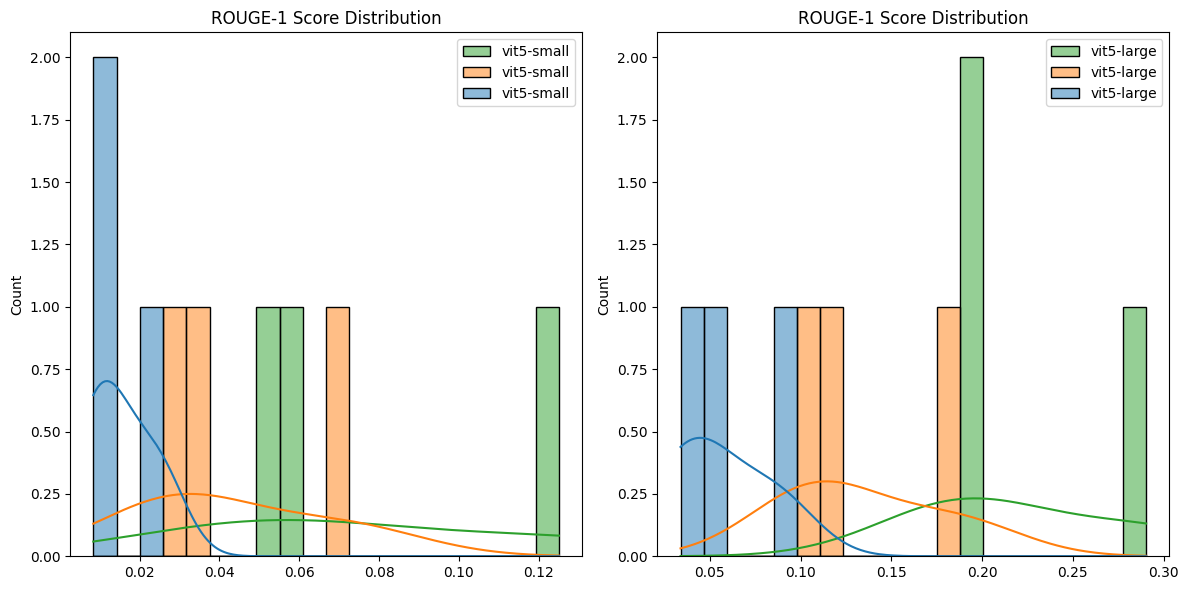

In [61]:
# Visualizar la distribución de puntuaciones ROUGE
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(results_vit5_base['rouge1'], bins=20, kde=True, color='blue', label='vit5-small')
plt.title('ROUGE-1 Score Distribution')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(results_vit5_large['rouge1'], bins=20, kde=True, color='orange', label='vit5-large')
plt.title('ROUGE-1 Score Distribution')
plt.legend()

plt.tight_layout()
plt.show()

# Text-Classification

## Pruebas con base-emotion

### Primera prueba con bert-base-uncased-emotion

In [67]:
emotion_dataset = load_dataset("dair-ai/emotion",
cache_dir= "local-datasets", trust_remote_code=True                
)
emotion_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [68]:
emotion_sample = emotion_dataset["train"].select(range(10))
display(emotion_sample.to_pandas()) 

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
5,ive been feeling a little burdened lately wasn...,0
6,ive been taking or milligrams or times recomme...,5
7,i feel as confused about life as a teenager or...,4
8,i have been with petronas for years i feel tha...,1
9,i feel romantic too,2


In [69]:
sentiment_classifier1 = pipeline(
    task="text-classification",
    model="bhadresh-savani/bert-base-uncased-emotion",
    model_kwargs={"cache_dir": "local-pipelines"},
)

In [70]:
results1 = sentiment_classifier1(emotion_sample["text"])

In [71]:
# Convertir los resultados a DataFrame y renombrar las columnas
results_df1 = pd.DataFrame.from_dict(results1).rename({"label": "predicted_label_pred"}, axis=1)

In [72]:
# Convertir la muestra a DataFrame y renombrar la columna 'label' a 'true_label'
emotion_sample_df = pd.DataFrame.from_dict(emotion_sample).rename({"label": "true_label"}, axis=1)

In [73]:
joined_data = (
    pd.DataFrame.from_dict(results1)
    .rename({"label": "predicted_label"}, axis=1)
    .join(pd.DataFrame.from_dict(emotion_sample).rename({"label": "true_label"}, axis=1))
)

In [74]:
# Realizar predicciones con el modelo
results = sentiment_classifier1(emotion_sample["text"])

# Convertir los resultados a DataFrame y renombrar la columna 'label' a 'predicted_label'
results_df = pd.DataFrame.from_dict(results).rename({"label": "predicted_label"}, axis=1)

# Convertir la muestra a DataFrame y renombrar la columna 'label_text' a 'true_label'
emotion_sample_df = pd.DataFrame.from_dict(emotion_sample).rename({"label_text": "true_label"}, axis=1)

# Unir los DataFrames utilizando un índice común y evitando la superposición de columnas
joined_data = results_df.join(emotion_sample_df, lsuffix='_pred', rsuffix='_true')

In [75]:
# Mostrar el resultado
print(joined_data)

  predicted_label     score  \
0         sadness  0.998652   
1         sadness  0.997222   
2           anger  0.997454   
3            love  0.995818   
4           anger  0.997975   
5         sadness  0.998811   
6        surprise  0.992818   
7            fear  0.994856   
8             joy  0.999023   
9            love  0.995234   

                                                text  label  
0                            i didnt feel humiliated      0  
1  i can go from feeling so hopeless to so damned...      0  
2   im grabbing a minute to post i feel greedy wrong      3  
3  i am ever feeling nostalgic about the fireplac...      2  
4                               i am feeling grouchy      3  
5  ive been feeling a little burdened lately wasn...      0  
6  ive been taking or milligrams or times recomme...      5  
7  i feel as confused about life as a teenager or...      4  
8  i have been with petronas for years i feel tha...      1  
9                                i fee

In [76]:
sentiment_labels = {0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"}
joined_data = joined_data.replace({"true_label": sentiment_labels})

display(joined_data[["predicted_label", "score", "text"]])

,predicted_label,score,text
0,sadness,0.998652,i didnt feel humiliated
1,sadness,0.997222,i can go from feeling so hopeless to so damned...
2,anger,0.997454,im grabbing a minute to post i feel greedy wrong
3,love,0.995818,i am ever feeling nostalgic about the fireplac...
4,anger,0.997975,i am feeling grouchy
5,sadness,0.998811,ive been feeling a little burdened lately wasn...
6,surprise,0.992818,ive been taking or milligrams or times recomme...
7,fear,0.994856,i feel as confused about life as a teenager or...
8,joy,0.999023,i have been with petronas for years i feel tha...
9,love,0.995234,i feel romantic too


In [77]:
# Convertir las predicciones y etiquetas verdaderas a DataFrame
results1 = sentiment_classifier1(emotion_sample["text"])
results_df1 = pd.DataFrame.from_dict(results1).rename({"label": "predicted_label1"}, axis=1)

### Segunda prueba con roberta-base-emotion

In [78]:
sentiment_classifier2 = pipeline(
    task="text-classification",
    model="bhadresh-savani/roberta-base-emotion",
    model_kwargs={"cache_dir": "local-pipelines"},
)

In [79]:
# Realizar predicciones con el segundo modelo
results2 = sentiment_classifier2(emotion_sample["text"])

In [80]:
emotion_sample = emotion_dataset["train"].select(range(10))
display(emotion_sample.to_pandas()) 

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
5,ive been feeling a little burdened lately wasn...,0
6,ive been taking or milligrams or times recomme...,5
7,i feel as confused about life as a teenager or...,4
8,i have been with petronas for years i feel tha...,1
9,i feel romantic too,2


In [81]:
results = sentiment_classifier2(emotion_sample["text"])

In [82]:
joined_data = (
    pd.DataFrame.from_dict(results)
    .rename({"label": "predicted_label"}, axis=1)
    .join(pd.DataFrame.from_dict(emotion_sample).rename({"label": "true_label"}, axis=1))
)

In [83]:
# Realizar predicciones con el modelo
results = sentiment_classifier2(emotion_sample["text"])

# Convertir los resultados a DataFrame y renombrar la columna 'label' a 'predicted_label'
results_df = pd.DataFrame.from_dict(results).rename({"label": "predicted_label"}, axis=1)

# Convertir la muestra a DataFrame y renombrar la columna 'label_text' a 'true_label'
emotion_sample_df = pd.DataFrame.from_dict(emotion_sample).rename({"label_text": "true_label"}, axis=1)

# Unir los DataFrames utilizando un índice común y evitando la superposición de columnas
joined_data = results_df.join(emotion_sample_df, lsuffix='_pred', rsuffix='_true')

In [84]:
# Mostrar el resultado
print(joined_data)

  predicted_label     score  \
0         sadness  0.991690   
1         sadness  0.990966   
2           anger  0.996561   
3            love  0.994575   
4           anger  0.997252   
5         sadness  0.998106   
6        surprise  0.988941   
7            fear  0.994377   
8             joy  0.998604   
9            love  0.995320   

                                                text  label  
0                            i didnt feel humiliated      0  
1  i can go from feeling so hopeless to so damned...      0  
2   im grabbing a minute to post i feel greedy wrong      3  
3  i am ever feeling nostalgic about the fireplac...      2  
4                               i am feeling grouchy      3  
5  ive been feeling a little burdened lately wasn...      0  
6  ive been taking or milligrams or times recomme...      5  
7  i feel as confused about life as a teenager or...      4  
8  i have been with petronas for years i feel tha...      1  
9                                i fee

In [85]:
sentiment_labels = {0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"}
joined_data = joined_data.replace({"true_label": sentiment_labels})

display(joined_data[["predicted_label", "score", "text"]])

,predicted_label,score,text
0,sadness,0.991690,i didnt feel humiliated
1,sadness,0.990966,i can go from feeling so hopeless to so damned...
2,anger,0.996561,im grabbing a minute to post i feel greedy wrong
3,love,0.994575,i am ever feeling nostalgic about the fireplac...
4,anger,0.997252,i am feeling grouchy
5,sadness,0.998106,ive been feeling a little burdened lately wasn...
6,surprise,0.988941,ive been taking or milligrams or times recomme...
7,fear,0.994377,i feel as confused about life as a teenager or...
8,joy,0.998604,i have been with petronas for years i feel tha...
9,love,0.995320,i feel romantic too


In [86]:
results2 = sentiment_classifier2(emotion_sample["text"])
results_df2 = pd.DataFrame.from_dict(results1).rename({"label": "predicted_label2"}, axis=1)

In [87]:
# Convertir la muestra a DataFrame y renombrar la columna 'label' a 'true_label'
emotion_sample_df = emotion_sample.to_pandas().rename(columns={"label": "true_label"})

In [88]:
# Unir los DataFrames utilizando un índice común y evitando la superposición de columnas
joined_data = pd.concat([emotion_sample_df, results_df1["predicted_label1"], results_df2["predicted_label2"]], axis=1)

In [89]:
# Asegurar que las etiquetas sean de tipo str
joined_data["true_label"] = joined_data["true_label"].astype(str)
joined_data["predicted_label1"] = joined_data["predicted_label1"].astype(str)
joined_data["predicted_label2"] = joined_data["predicted_label2"].astype(str)

### Analisis con Acuracy de base-emotion

In [90]:
# Convertir los resultados a DataFrame y renombrar las columnas
results_df1 = pd.DataFrame.from_dict(results1).rename({"label": "predicted_label_pred"}, axis=1)
results_df2 = pd.DataFrame.from_dict(results2).rename({"label": "predicted_label_true"}, axis=1)

#### Calculo de Precision 

In [91]:
# Calcular la precisión del primer modelo
accuracy_model1 = accuracy_score(joined_data["true_label"], joined_data["predicted_label1"])

# Calcular la precisión del segundo modelo
accuracy_model2 = accuracy_score(joined_data["true_label"], joined_data["predicted_label2"])

print(f"Precisión del Modelo 1: {accuracy_model1:.2f}")
print(f"Precisión del Modelo 2: {accuracy_model2:.2f}")

Precisión del Modelo 1: 0.00
Precisión del Modelo 2: 0.00


#### Matriz de Confusion

In [92]:
# Crear listas de etiquetas verdaderas y predichas para cada modelo
true_labels = joined_data["true_label"]
pred_labels_model1 = joined_data["predicted_label1"]
pred_labels_model2 = joined_data["predicted_label2"]

In [93]:
# Etiquetas de sentimiento (usadas por ambos modelos)
sentiment_labels_model1 = list(set(joined_data["true_label"].unique()).union(set(joined_data["predicted_label1"].unique())))
sentiment_labels_model2 = list(set(joined_data["true_label"].unique()).union(set(joined_data["predicted_label2"].unique())))

# Obtener la matriz de confusión del primer modelo
cm_model1 = confusion_matrix(joined_data["true_label"], joined_data["predicted_label1"], labels=sentiment_labels_model1)

# Obtener la matriz de confusión del segundo modelo
cm_model2 = confusion_matrix(joined_data["true_label"], joined_data["predicted_label2"], labels=sentiment_labels_model2)

##### Para el primer modelo

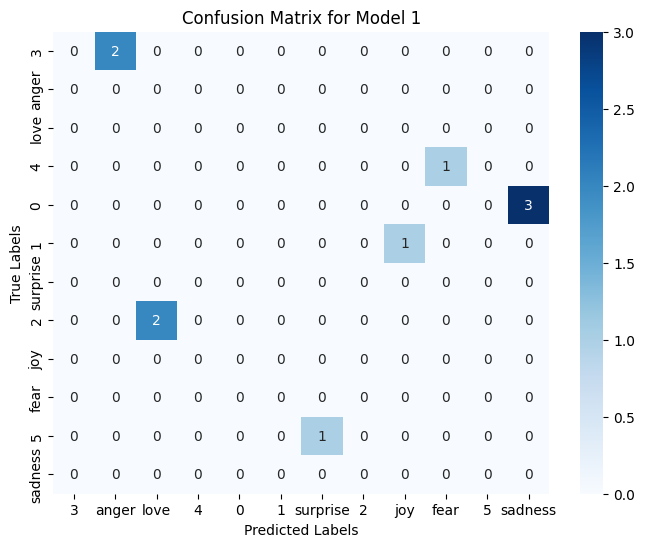

In [94]:
# Crear un mapa de calor para visualizar la matriz de confusión del primer modelo
plt.figure(figsize=(8, 6))
sns.heatmap(cm_model1, annot=True, fmt='d', cmap='Blues', xticklabels=sentiment_labels_model1, yticklabels=sentiment_labels_model1)
plt.title('Confusion Matrix for Model 1')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

##### Para el segundo modelo

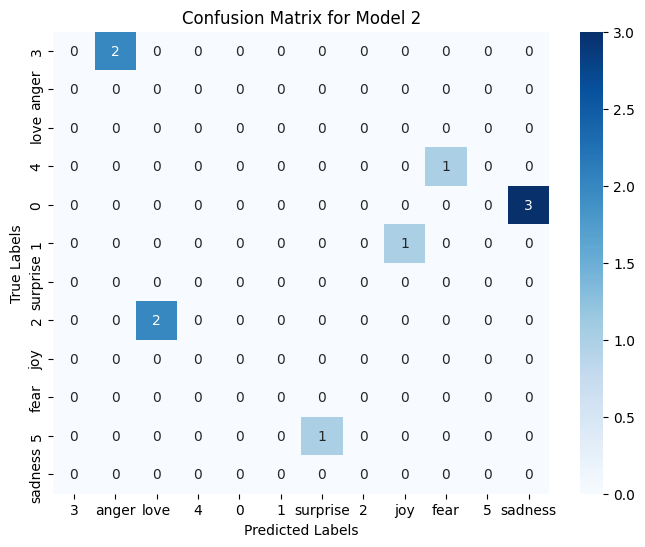

In [95]:
# Crear un mapa de calor para visualizar la matriz de confusión del segundo modelo
plt.figure(figsize=(8, 6))
sns.heatmap(cm_model2, annot=True, fmt='d', cmap='Blues', xticklabels=sentiment_labels_model2, yticklabels=sentiment_labels_model2)
plt.title('Confusion Matrix for Model 2')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#### Curva de ROC y AUC

In [96]:
# Binarizar las etiquetas verdaderas y las predicciones de ambos modelos
true_labels_binarized = label_binarize(joined_data["true_label"], classes=sentiment_labels_model1)
pred_labels_binarized_model1 = label_binarize(joined_data["predicted_label1"], classes=sentiment_labels_model1)
pred_labels_binarized_model2 = label_binarize(joined_data["predicted_label2"], classes=sentiment_labels_model2)


In [97]:
# Calcular las curvas ROC y AUC para cada clase del primer modelo
fpr_model1 = dict()
tpr_model1 = dict()
roc_auc_model1 = dict()
for i in range(len(sentiment_labels_model1)):
    fpr_model1[i], tpr_model1[i], _ = roc_curve(true_labels_binarized[:, i], pred_labels_binarized_model1[:, i])
    roc_auc_model1[i] = auc(fpr_model1[i], tpr_model1[i])


C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\

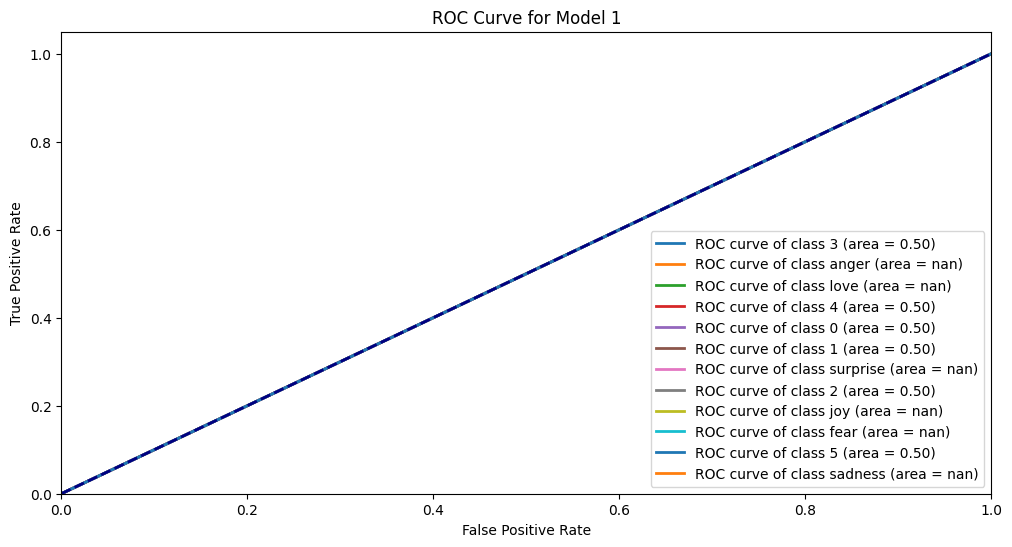

In [98]:
# Plotear las curvas ROC para el primer modelo
plt.figure(figsize=(12, 6))
for i in range(len(sentiment_labels_model1)):
    plt.plot(fpr_model1[i], tpr_model1[i], lw=2, label=f'ROC curve of class {sentiment_labels_model1[i]} (area = {roc_auc_model1[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Model 1')
plt.legend(loc="lower right")
plt.show()    

In [99]:
# Calcular las curvas ROC y AUC para cada clase del segundo modelo
fpr_model2 = dict()
tpr_model2 = dict()
roc_auc_model2 = dict()
for i in range(len(sentiment_labels_model2)):
    fpr_model2[i], tpr_model2[i], _ = roc_curve(true_labels_binarized[:, i], pred_labels_binarized_model2[:, i])
    roc_auc_model2[i] = auc(fpr_model2[i], tpr_model2[i])

C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\

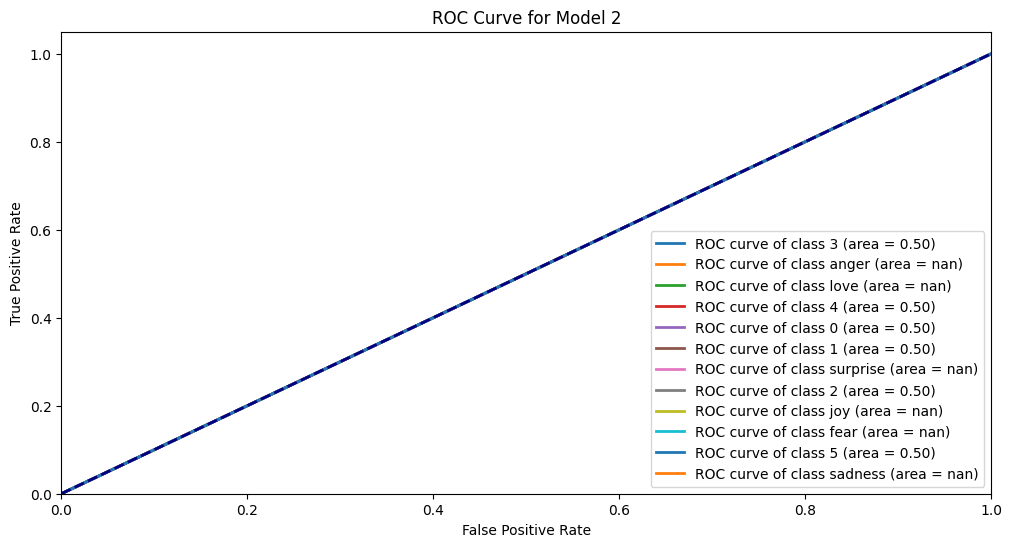

In [100]:
# Plotear las curvas ROC para el segundo modelo
plt.figure(figsize=(12, 6))
for i in range(len(sentiment_labels_model2)):
    plt.plot(fpr_model2[i], tpr_model2[i], lw=2, label=f'ROC curve of class {sentiment_labels_model2[i]} (area = {roc_auc_model2[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Model 2')
plt.legend(loc="lower right")
plt.show()

#### Precision, Recall, F1-score por clase

In [101]:
# Calcular métricas para el primer modelo
report_model1 = classification_report(joined_data["true_label"], joined_data["predicted_label1"], target_names=sentiment_labels_model1, zero_division=0)
print("Classification Report for Model 1:\n", report_model1)

# Calcular métricas para el segundo modelo
report_model2 = classification_report(joined_data["true_label"], joined_data["predicted_label2"], target_names=sentiment_labels_model2, zero_division=0)
print("\nClassification Report for Model 2:\n", report_model2)

Classification Report for Model 1:
               precision    recall  f1-score   support

           3       0.00      0.00      0.00       3.0
       anger       0.00      0.00      0.00       1.0
        love       0.00      0.00      0.00       2.0
           4       0.00      0.00      0.00       2.0
           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       1.0
    surprise       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00       0.0
         joy       0.00      0.00      0.00       0.0
        fear       0.00      0.00      0.00       0.0
           5       0.00      0.00      0.00       0.0
     sadness       0.00      0.00      0.00       0.0

    accuracy                           0.00      10.0
   macro avg       0.00      0.00      0.00      10.0
weighted avg       0.00      0.00      0.00      10.0


Classification Report for Model 2:
               precision    recall  f1-score   support

     

## Pruebas con uncased-emotions

### 1ra prueba con albert-base

In [62]:
sentiment_classifier3 = pipeline(
    task="text-classification",
    model="bhadresh-savani/albert-base-v2-emotion",
    model_kwargs={"cache_dir": "local-pipelines"},
)

In [102]:
# Realizar predicciones con el segundo modelo
results3 = sentiment_classifier3(emotion_sample["text"])

In [103]:
emotion_sample = emotion_dataset["train"].select(range(10))
display(emotion_sample.to_pandas()) 

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
5,ive been feeling a little burdened lately wasn...,0
6,ive been taking or milligrams or times recomme...,5
7,i feel as confused about life as a teenager or...,4
8,i have been with petronas for years i feel tha...,1
9,i feel romantic too,2


In [104]:
results = sentiment_classifier3(emotion_sample["text"])

In [105]:
joined_data = (
    pd.DataFrame.from_dict(results)
    .rename({"label": "predicted_label"}, axis=1)
    .join(pd.DataFrame.from_dict(emotion_sample).rename({"label": "true_label"}, axis=1))
)

In [106]:
# Realizar predicciones con el modelo
results = sentiment_classifier3(emotion_sample["text"])

# Convertir los resultados a DataFrame y renombrar la columna 'label' a 'predicted_label'
results_df = pd.DataFrame.from_dict(results).rename({"label": "predicted_label"}, axis=1)

# Convertir la muestra a DataFrame y renombrar la columna 'label_text' a 'true_label'
emotion_sample_df = pd.DataFrame.from_dict(emotion_sample).rename({"label_text": "true_label"}, axis=1)

# Unir los DataFrames utilizando un índice común y evitando la superposición de columnas
joined_data = results_df.join(emotion_sample_df, lsuffix='_pred', rsuffix='_true')

In [107]:
# Mostrar el resultado
print(joined_data)

  predicted_label     score  \
0         sadness  0.994839   
1         sadness  0.994982   
2           anger  0.995903   
3            love  0.986565   
4           anger  0.992961   
5         sadness  0.995896   
6        surprise  0.976490   
7            fear  0.981321   
8             joy  0.997841   
9            love  0.976894   

                                                text  label  
0                            i didnt feel humiliated      0  
1  i can go from feeling so hopeless to so damned...      0  
2   im grabbing a minute to post i feel greedy wrong      3  
3  i am ever feeling nostalgic about the fireplac...      2  
4                               i am feeling grouchy      3  
5  ive been feeling a little burdened lately wasn...      0  
6  ive been taking or milligrams or times recomme...      5  
7  i feel as confused about life as a teenager or...      4  
8  i have been with petronas for years i feel tha...      1  
9                                i fee

In [108]:
sentiment_labels = {0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"}
joined_data = joined_data.replace({"true_label": sentiment_labels})

display(joined_data[["predicted_label", "score", "text"]])

,predicted_label,score,text
0,sadness,0.994839,i didnt feel humiliated
1,sadness,0.994982,i can go from feeling so hopeless to so damned...
2,anger,0.995903,im grabbing a minute to post i feel greedy wrong
3,love,0.986565,i am ever feeling nostalgic about the fireplac...
4,anger,0.992961,i am feeling grouchy
5,sadness,0.995896,ive been feeling a little burdened lately wasn...
6,surprise,0.976490,ive been taking or milligrams or times recomme...
7,fear,0.981321,i feel as confused about life as a teenager or...
8,joy,0.997841,i have been with petronas for years i feel tha...
9,love,0.976894,i feel romantic too


In [110]:
results3 = sentiment_classifier3(emotion_sample["text"])
results_df3 = pd.DataFrame.from_dict(results1).rename({"label": "predicted_label3"}, axis=1)

In [111]:
# Convertir la muestra a DataFrame y renombrar la columna 'label' a 'true_label'
emotion_sample_df = emotion_sample.to_pandas().rename(columns={"label": "true_label"})

### 2da prueba con distilbert-base-uncased-emotion

In [112]:
sentiment_classifier4 = pipeline(
    task="text-classification",
    model="bhadresh-savani/distilbert-base-uncased-emotion",
    model_kwargs={"cache_dir": "local-pipelines"},
)

In [113]:
# Realizar predicciones con el segundo modelo
results4 = sentiment_classifier4(emotion_sample["text"])

In [114]:
emotion_sample = emotion_dataset["train"].select(range(10))
display(emotion_sample.to_pandas()) 

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
5,ive been feeling a little burdened lately wasn...,0
6,ive been taking or milligrams or times recomme...,5
7,i feel as confused about life as a teenager or...,4
8,i have been with petronas for years i feel tha...,1
9,i feel romantic too,2


In [115]:
results = sentiment_classifier4(emotion_sample["text"])

In [116]:
joined_data = (
    pd.DataFrame.from_dict(results)
    .rename({"label": "predicted_label"}, axis=1)
    .join(pd.DataFrame.from_dict(emotion_sample).rename({"label": "true_label"}, axis=1))
)

In [117]:
# Realizar predicciones con el modelo
results = sentiment_classifier4(emotion_sample["text"])

# Convertir los resultados a DataFrame y renombrar la columna 'label' a 'predicted_label'
results_df = pd.DataFrame.from_dict(results).rename({"label": "predicted_label"}, axis=1)

# Convertir la muestra a DataFrame y renombrar la columna 'label_text' a 'true_label'
emotion_sample_df = pd.DataFrame.from_dict(emotion_sample).rename({"label_text": "true_label"}, axis=1)

# Unir los DataFrames utilizando un índice común y evitando la superposición de columnas
joined_data = results_df.join(emotion_sample_df, lsuffix='_pred', rsuffix='_true')

In [118]:
# Mostrar el resultado
print(joined_data)

  predicted_label     score  \
0         sadness  0.998991   
1         sadness  0.998832   
2           anger  0.997787   
3            love  0.995399   
4           anger  0.998039   
5         sadness  0.998992   
6        surprise  0.989611   
7            fear  0.993577   
8             joy  0.998782   
9            love  0.995559   

                                                text  label  
0                            i didnt feel humiliated      0  
1  i can go from feeling so hopeless to so damned...      0  
2   im grabbing a minute to post i feel greedy wrong      3  
3  i am ever feeling nostalgic about the fireplac...      2  
4                               i am feeling grouchy      3  
5  ive been feeling a little burdened lately wasn...      0  
6  ive been taking or milligrams or times recomme...      5  
7  i feel as confused about life as a teenager or...      4  
8  i have been with petronas for years i feel tha...      1  
9                                i fee

In [119]:
sentiment_labels = {0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"}
joined_data = joined_data.replace({"true_label": sentiment_labels})

display(joined_data[["predicted_label", "score", "text"]])

,predicted_label,score,text
0,sadness,0.998991,i didnt feel humiliated
1,sadness,0.998832,i can go from feeling so hopeless to so damned...
2,anger,0.997787,im grabbing a minute to post i feel greedy wrong
3,love,0.995399,i am ever feeling nostalgic about the fireplac...
4,anger,0.998039,i am feeling grouchy
5,sadness,0.998992,ive been feeling a little burdened lately wasn...
6,surprise,0.989611,ive been taking or milligrams or times recomme...
7,fear,0.993577,i feel as confused about life as a teenager or...
8,joy,0.998782,i have been with petronas for years i feel tha...
9,love,0.995559,i feel romantic too


In [120]:
results4 = sentiment_classifier4(emotion_sample["text"])
results_df4 = pd.DataFrame.from_dict(results1).rename({"label": "predicted_label4"}, axis=1)

In [121]:
# Convertir la muestra a DataFrame y renombrar la columna 'label' a 'true_label'
emotion_sample_df = emotion_sample.to_pandas().rename(columns={"label": "true_label"})

In [122]:
# Unir los DataFrames utilizando un índice común y evitando la superposición de columnas
joined_data = pd.concat([emotion_sample_df, results_df3["predicted_label3"], results_df4["predicted_label4"]], axis=1)

In [123]:
# Asegurar que las etiquetas sean de tipo str
joined_data["true_label"] = joined_data["true_label"].astype(str)
joined_data["predicted_label3"] = joined_data["predicted_label3"].astype(str)
joined_data["predicted_label4"] = joined_data["predicted_label4"].astype(str)

### Analisis con Acuracy de uncased-emotions

In [124]:
# Convertir los resultados a DataFrame y renombrar las columnas
results_df3 = pd.DataFrame.from_dict(results3).rename({"label": "predicted_label_pred"}, axis=1)
results_df4 = pd.DataFrame.from_dict(results4).rename({"label": "predicted_label_true"}, axis=1)

##### Calculo de presicion

In [125]:
# Calcular la precisión del primer modelo
accuracy_model3 = accuracy_score(joined_data["true_label"], joined_data["predicted_label3"])

# Calcular la precisión del segundo modelo
accuracy_model4 = accuracy_score(joined_data["true_label"], joined_data["predicted_label4"])

print(f"Precisión del Modelo 3: {accuracy_model3:.2f}")
print(f"Precisión del Modelo 4: {accuracy_model4:.2f}")

Precisión del Modelo 3: 0.00
Precisión del Modelo 4: 0.00


#### Matrices de confusion

In [126]:
# Crear listas de etiquetas verdaderas y predichas para cada modelo
true_labels = joined_data["true_label"]
pred_labels_model3 = joined_data["predicted_label3"]
pred_labels_model4 = joined_data["predicted_label4"]

In [127]:
# Etiquetas de sentimiento (usadas por ambos modelos)
sentiment_labels_model3 = list(set(joined_data["true_label"].unique()).union(set(joined_data["predicted_label3"].unique())))
sentiment_labels_model4 = list(set(joined_data["true_label"].unique()).union(set(joined_data["predicted_label4"].unique())))

# Obtener la matriz de confusión del primer modelo
cm_model3 = confusion_matrix(joined_data["true_label"], joined_data["predicted_label3"], labels=sentiment_labels_model3)

# Obtener la matriz de confusión del segundo modelo
cm_model4 = confusion_matrix(joined_data["true_label"], joined_data["predicted_label3"], labels=sentiment_labels_model4)

#### Curva de ROC y AUC

In [128]:
# Binarizar las etiquetas verdaderas y las predicciones de ambos modelos
true_labels_binarized = label_binarize(joined_data["true_label"], classes=sentiment_labels_model3)
pred_labels_binarized_model3 = label_binarize(joined_data["predicted_label3"], classes=sentiment_labels_model3)
pred_labels_binarized_model4 = label_binarize(joined_data["predicted_label4"], classes=sentiment_labels_model4)


In [129]:
# Calcular las curvas ROC y AUC para cada clase del tercer modelo
fpr_model3 = dict()
tpr_model3 = dict()
roc_auc_model3 = dict()
for i in range(len(sentiment_labels_model3)):
    fpr_model3[i], tpr_model3[i], _ = roc_curve(true_labels_binarized[:, i], pred_labels_binarized_model3[:, i])
    roc_auc_model3[i] = auc(fpr_model3[i], tpr_model3[i])

C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\

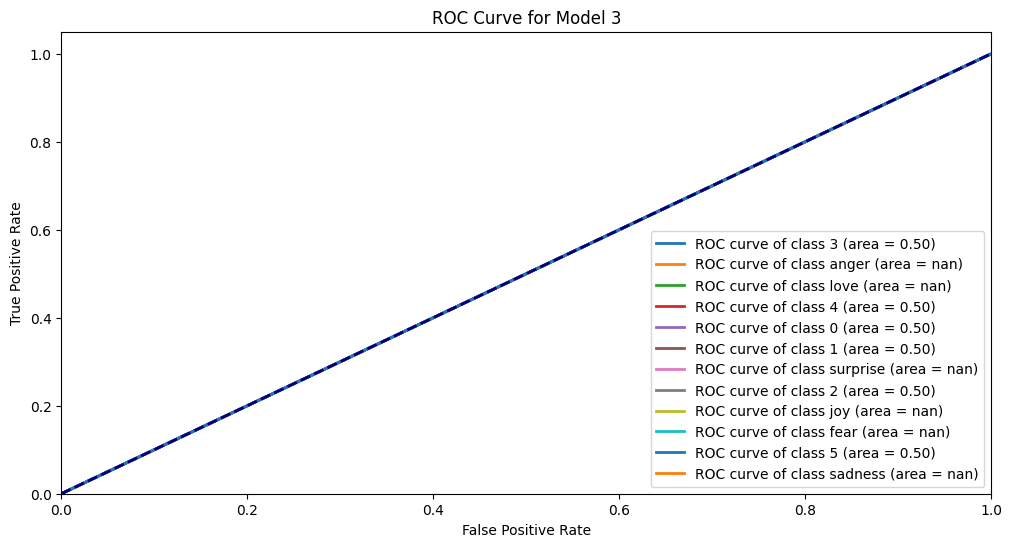

In [130]:
# Plotear las curvas ROC para el primer modelo
plt.figure(figsize=(12, 6))
for i in range(len(sentiment_labels_model3)):
    plt.plot(fpr_model3[i], tpr_model3[i], lw=2, label=f'ROC curve of class {sentiment_labels_model3[i]} (area = {roc_auc_model3[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Model 3')
plt.legend(loc="lower right")
plt.show()    

In [131]:
# Calcular las curvas ROC y AUC para cada clase del segundo modelo
fpr_model4 = dict()
tpr_model4 = dict()
roc_auc_model4 = dict()
for i in range(len(sentiment_labels_model4)):
    fpr_model4[i], tpr_model4[i], _ = roc_curve(true_labels_binarized[:, i], pred_labels_binarized_model4[:, i])
    roc_auc_model4[i] = auc(fpr_model4[i], tpr_model4[i])

C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\

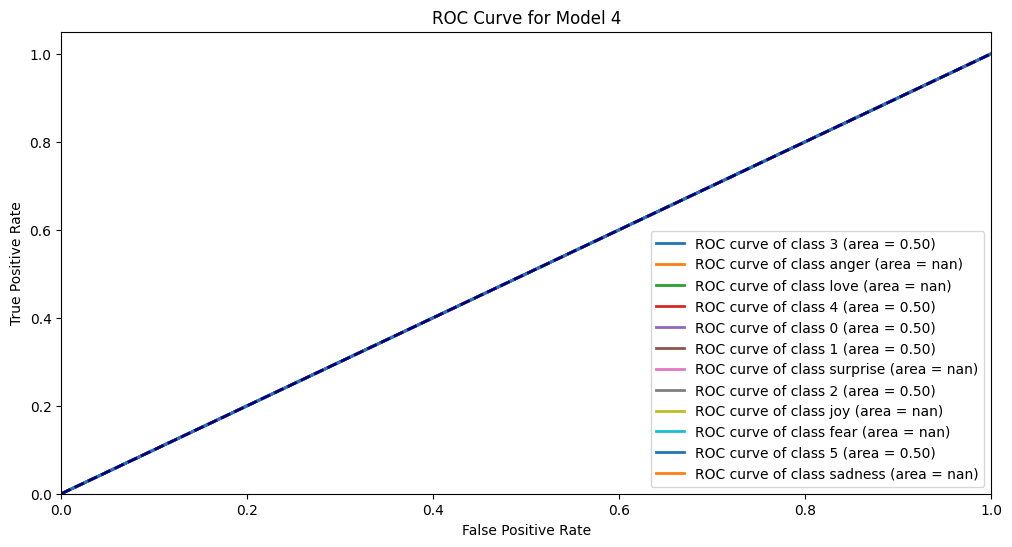

In [132]:
# Plotear las curvas ROC para el segundo modelo
plt.figure(figsize=(12, 6))
for i in range(len(sentiment_labels_model4)):
    plt.plot(fpr_model4[i], tpr_model4[i], lw=2, label=f'ROC curve of class {sentiment_labels_model4[i]} (area = {roc_auc_model4[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Model 4')
plt.legend(loc="lower right")
plt.show()

#### Precision, Recall, F1-score por clase

In [133]:
# Calcular métricas para el primer modelo
report_model3 = classification_report(joined_data["true_label"], joined_data["predicted_label3"], target_names=sentiment_labels_model3, zero_division=0)
print("Classification Report for Model 3:\n", report_model3)

# Calcular métricas para el segundo modelo
report_model4 = classification_report(joined_data["true_label"], joined_data["predicted_label4"], target_names=sentiment_labels_model4, zero_division=0)
print("\nClassification Report for Model 2:\n", report_model4)

Classification Report for Model 3:
               precision    recall  f1-score   support

           3       0.00      0.00      0.00       3.0
       anger       0.00      0.00      0.00       1.0
        love       0.00      0.00      0.00       2.0
           4       0.00      0.00      0.00       2.0
           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       1.0
    surprise       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00       0.0
         joy       0.00      0.00      0.00       0.0
        fear       0.00      0.00      0.00       0.0
           5       0.00      0.00      0.00       0.0
     sadness       0.00      0.00      0.00       0.0

    accuracy                           0.00      10.0
   macro avg       0.00      0.00      0.00      10.0
weighted avg       0.00      0.00      0.00      10.0


Classification Report for Model 2:
               precision    recall  f1-score   support

     

# Translation

## Pruebas con Google-t5

### 1ra prueba con Google t5-small

In [138]:
# Descarga del dataset a utilizar 
translation_dataset = load_dataset("Iker/InstructTranslation-EN-ES-Raw",
cache_dir= "local-datasets", trust_remote_code=True                
)
translation_dataset

DatasetDict({
    train: Dataset({
        features: ['example_no', 'conversation_no', 'from', 'conversation', 'translation'],
        num_rows: 1459
    })
})

In [139]:
translation_sample = translation_dataset["train"].select(range(10))
display(translation_sample.to_pandas()) 

,example_no,conversation_no,from,conversation,translation
0,173436,0,human,Consider a string of characters in which each ...,Considere una cadena de caracteres en la que c...
1,173436,1,gpt,"Yes, I can create an equation that evaluates t...","Sí, puedo crear una ecuación que evalúe al pri..."
2,377064,0,human,I am currently building a web application in g...,Actualmente estoy construyendo una aplicación ...
3,377064,1,gpt,Gorilla has a router that you can use to handl...,Gorilla tiene un enrutador que puedes usar par...
4,513335,0,system,You are an AI assistant. User will you give yo...,Eres un asistente de IA. El usuario te dará un...
5,513335,1,human,Digestion is the breakdown of large insoluble ...,La digestión es la descomposición de moléculas...
6,513335,2,gpt,"In some organisms, these small water-soluble f...","En algunos organismos, estas pequeñas molécula..."
7,81968,0,human,"How long is the Peano curve of order 4, given ...","¿Cuánto mide la curva de Peano de orden 4, dad..."
8,81968,1,gpt,"The Peano curve is a space-filling curve, and ...",La curva de Peano es una curva que llena el es...
9,757182,0,system,You are an AI assistant. Provide a detailed an...,Eres un asistente de IA. Proporciona una respu...


In [140]:
translation_pipeline1 = pipeline(
    task="translation",
    model="google-t5/t5-small",
    model_kwargs={"cache_dir": "local-pipelines"}
)

C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\pipelines\__init__.py:1076: UserWarning: "translation" task was used, instead of "translation_XX_to_YY", defaulting to "translation_en_to_de"
  warnings.warn(


In [141]:
predictions_model1 = [translation_pipeline1(content, max_length=700)[0]['translation_text'] for content in translation_sample["conversation"]]
references_model1 = translation_dataset["train"].select(range(10))

In [142]:
print(translation_sample["conversation"][0])

Consider a string of characters in which each character represents a unique digit from 0 to 9. 
Using any mathematical operators (+, -, *, /), can you create an equation that evaluates to the first digit of the string?
For example, if the string is "48296", the equation could be:
8 + 4 - 2 * 9 / 6 = 8
Note: The equation should only use the characters in the string and should not include any additional numbers or digits.


In [143]:
translation = translation_pipeline1(translation_sample["conversation"][0])
print(translation)

[{'translation_text': 'Wenn es sich um eine Zeichenkette handelt, in der jedes Zeichen eine eindeutige Ziffer von 0 bis 9 darstellt, können Sie mit beliebigen mathematischen Operatoren (+, -, *, /) eine Gleichung erstellen, die sich auf die erste Ziffer des Strings evaluiert?'}]


In [144]:
print(translation_sample["conversation"][1])

Yes, I can create an equation that evaluates to the first digit of the string. Here's an example:
((9 - 6) * 4) / 8 + 2 - 0 - 3 - 5 + 7 = 1
This equation uses all of the digits in the string "9035721486" and evaluates to the first digit, which is 1. Note that the order of operations is important in this equation.


In [145]:
translation = translation_pipeline1(translation_sample["conversation"][1])
print(translation)

[{'translation_text': 'Ja, ich kann eine Gleichung erstellen, die auf die erste Ziffer des Strings bewertet.'}]


In [146]:
print(translation_sample["conversation"][2])

I am currently building a web application in golang (with Gorilla) and have implemented a handful of API endpoints. However, I noticed that every time I implement a function like:

```go
func CreateUserHandler(w http.ResponseWriter, r *http.Request) {}
```

I have to add the function below to the body of handler functions to check if the request is authorized:

```go
func checkAuthorizedUser(r *http.Request) error {
    uid, err := CheckRequestUser(r.Cookie("uid"))
    if err != nil {
        return errors.New("Can't find cookie value for uid")
    }
    if !IsValidUser(uid.Value) { 
        return errors.New("Not a valid user")
    }
    return nil
}
```

What happens to me right now is that I have to add `checkAuthorizedUser()` to every handler function, and I already have a lot of handler functions so far. I wonder if there is a better way to check whether a client is authorized to access a certain endpoint other than explicitly checking authentication in every handler function.


In [147]:
translation = translation_pipeline1(translation_sample["conversation"][2])
print(translation)

Your input_length: 316 is bigger than 0.9 * max_length: 300. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


[{'translation_text': 'Ich baue derzeit eine Web-Anwendung in golang (mit Gorilla) und habe eine Handvoll API-Endpoints implementiert, aber ich habe festgestellt, dass jedes Mal, wenn ich eine Funktion wie: go func CreateUserHandler(w http.ResponseWriter, r *http.Request)   Ich muss die Funktion unten in den Körper der Handhaber Funktionen hinzufügen, um zu überprüfen, ob die Anfrage'}]


In [148]:
print(translation_sample["conversation"][3])

Gorilla has a router that you can use to handle your API endpoints. You can wrap the router with authentication checking to automatically check if the request is authorized. Here's an example of how you can do it:

```go
func checkPermissions(h http.Handler) http.HandlerFunc {
    return func(w http.ResponseWriter, r *http.Request) {
        // Implement the actual authentication checking here
        authCheck := true

        if authCheck {
            http.Error(w, "Unauthorized", http.StatusUnauthorized)
            return
        }

        h.ServeHTTP(w, r)
    }
}

func main() {
    r := mux.NewRouter()
    r.HandleFunc("/", HomeHandler)
    r.HandleFunc("/products", ProductsHandler)
    r.HandleFunc("/articles", ArticlesHandler)
    
    http.Handle("/", checkPermissions(r))
}
```

In this example, we define a `checkPermissions` function that takes a handler as input and returns a new handler function. Inside the `checkPermissions` function, you can implement your authenticatio

In [149]:
translation = translation_pipeline1(translation_sample["conversation"][3])
print(translation)

Your input_length: 501 is bigger than 0.9 * max_length: 300. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


[{'translation_text': 'Gorilla hat einen Router, den Sie verwenden können, um Ihre API-Endpoints zu verwalten, und Sie können den Router mit der Authentifizierungsprüfung umfassen, um automatisch zu überprüfen, ob die Anfrage genehmigt ist.'}]


In [150]:
print(translation_sample["conversation"][4])

You are an AI assistant. User will you give you a task. Your goal is to complete the task as faithfully as you can. While performing the task think step-by-step and justify your steps.


In [151]:
translation = translation_pipeline1(translation_sample["conversation"][4])
print(translation)

[{'translation_text': 'Sie sind ein AI-Assistent.'}]


In [152]:
print(translation_sample["conversation"][5])

Digestion is the breakdown of large insoluble food molecules into small water-soluble food molecules so that they can be absorbed into the watery blood plasma. In certain organisms, these smaller substances are absorbed through the small intestine into the blood stream. Digestion is a form of catabolism that is often divided into two processes based on how food is broken down: mechanical and chemical digestion. The term mechanical digestion refers to the physical breakdown of large pieces of food into smaller pieces which can subsequently be accessed by digestive enzymes. In chemical digestion, enzymes break down food into the small molecules the body can use.
Is there an answer to this question (If it cannot be answered, say "unanswerable"): In some organisms, how are these molecules absorbed?


In [153]:
translation = translation_pipeline1(translation_sample["conversation"][5])
print(translation)

[{'translation_text': 'Digestion ist eine Form des Katabolismus, der oft in zwei Prozesse unterteilt wird, die darauf basieren, wie die Nahrung zersplittert wird: mechanische und chemische Verdauung.'}]


In [154]:
print(translation_sample["conversation"][6])

In some organisms, these small water-soluble food molecules are absorbed through a process called diffusion or active transport in the small intestine. 

Step-by-step:

1. After mechanical and chemical digestion has taken place, the food particles become small, water-soluble molecules.
2. These molecules reach the small intestine, which is lined with tiny, finger-like projections called villi.
3. Villi increase the surface area available for absorption, allowing more molecules to be absorbed simultaneously.
4. Microvilli, even smaller finger-like projections on the villi, further increase the surface area and efficiency of absorption.
5. The small molecules, such as glucose, amino acids, and fatty acids, pass through the cells of the villi by diffusion or active transport.
6. Diffusion: Molecules move from an area of higher concentration to an area of lower concentration, passively absorbing into the bloodstream.
7. Active transport: Molecules are transported across the cell membrane u

In [155]:
translation = translation_pipeline1(translation_sample["conversation"][6])
print(translation)

Your input_length: 300 is bigger than 0.9 * max_length: 300. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


[{'translation_text': 'In einigen Organismen werden diese kleinen wasserlöslichen Lebensmittelmoleküle durch einen Prozess namens Diffusion oder aktiver Transport im Darm absorbiert. Schritt für Schritt: 1. Nach der mechanischen und chemischen Verdauung werden die Lebensmittelpartikel kleine, wasserlösliche Moleküle. 2. Diese Moleküle erreichen den kleinen Darm, der mit winzigen, fingerartigen Projektionen namens villi gesäubert wird. 3. Vi'}]


In [156]:
translation = translation_pipeline1(translation_sample["conversation"][7])
print(translation)

[{'translation_text': 'Wie lange ist die Peano Kurve der Reihenfolge 4, da jedes Segment der Kurve 1 Einheit lang ist?'}]


In [157]:
print(translation_sample["conversation"][7])

How long is the Peano curve of order 4, given that each segment of the curve is 1 unit long?


In [158]:
print(translation_sample["conversation"][8])

The Peano curve is a space-filling curve, and its length increases with each order. In the Peano curve, the number of segments in each order is given by the formula:

Number of segments = 3^(order)

For order 4, we have:

Number of segments = 3^4 = 81

Since each segment is 1 unit long, the length of the Peano curve of order 4 is 81 units.


In [159]:
translation = translation_pipeline1(translation_sample["conversation"][8])
print(translation)

[{'translation_text': 'In der Peano-Kurve wird die Anzahl der Segmente in jeder Reihenfolge durch die Formel angegeben: Anzahl der Segmente = 3(Ordnung) Für die Reihenfolge 4 haben wir: Anzahl der Segmente = 34 = 81 Da jedes Segment 1 Einheit lang ist, ist die Länge der Peano-Kurve der Reihenfolge 4 81 Einheiten.'}]


In [160]:
print(translation_sample["conversation"][9])

You are an AI assistant. Provide a detailed answer so user don’t need to search outside to understand the answer.


In [161]:
translation = translation_pipeline1(translation_sample["conversation"][9])
print(translation)

[{'translation_text': 'Sie sind ein AI-Assistent und geben eine detaillierte Antwort an, damit der Anwender nicht nach außen suchen muss, um die Antwort zu verstehen.'}]


In [162]:
translations_opus = []

for i in range(10):
    # Aquí se realiza cada predicción y se guarda en `translation`
    translation = translation_pipeline1(translation_sample["conversation"][i])
    
    # Agregar `translation` a `translations_opus`
    translations_opus.append(translation)

Your input_length: 316 is bigger than 0.9 * max_length: 300. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
Your input_length: 501 is bigger than 0.9 * max_length: 300. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
Your input_length: 300 is bigger than 0.9 * max_length: 300. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


### 2da prueba con Google t5-base

In [163]:
# Seleccionar una muestra del dataset
translation_sample = translation_dataset["train"].select(range(10))

In [164]:
translation_pipeline2 = pipeline(
    task="translation",
    model="google-t5/t5-base",
    model_kwargs={"cache_dir": "local-pipelines"},
)

Error while downloading from https://cdn-lfs.huggingface.co/t5-base/a90903540cc02cbeb7ff9f823f1a80eb778c7e22426a0e620b01c77a5ec8f5b4?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1720997680&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMDk5NzY4MH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby90NS1iYXNlL2E5MDkwMzU0MGNjMDJjYmViN2ZmOWY4MjNmMWE4MGViNzc4YzdlMjI0MjZhMGU2MjBiMDFjNzdhNWVjOGY1YjQ%7EcmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qIn1dfQ__&Signature=kZ2KpF33ZVrFVL2j92slXcMpDXeKP3sUIVQoXkTt9ba2hw4DzsyhejWoX%7EskJcXCmjIzEkaSRH-4e4HS8-2pWcY5qIgN4EqdUUJxoHeQ0GIA3kPn3FzJLFTEBgaNcN2EOv4ZBcPUY0p8gdc5khghynZftF3rGw2fRO1IPIqP%7Ee2A39JGOs8dAw9qyietftKrpH8CCdepllSvCxGk0kmbgY6Vh2WpYLDTOPdmqpXoJuGcN2tbC2%7Eiu1I41B5vyMxFnfMvLQ6n0INPviZz7GGKe0g2VvFZls8fhBPWSbFwOcIwvhReXcdoqo4wNN7zdzAfftkHFpCNOp7Wad1MzmL2kw__&Key-Pair-Id=K3ESJI6DHPFC7: HTTPSConnectionPool(host='cdn

In [ ]:
predictions_model2 = [translation_pipeline1(content, max_length=700)[0]['translation_text'] for content in translation_sample["conversation"]]
references_model2 = translation_dataset["train"].select(range(10))

In [ ]:
print(translation_sample["conversation"][0])

In [ ]:
translation = translation_pipeline2(translation_sample["conversation"][0])
print(translation)

In [ ]:
print(translation_sample["conversation"][1])

In [ ]:
translation = translation_pipeline2(translation_sample["conversation"][1])
print(translation)

In [ ]:
print(translation_sample["conversation"][2])

In [ ]:
translation = translation_pipeline2(translation_sample["conversation"][2])
print(translation)

In [ ]:
print(translation_sample["conversation"][3])

In [ ]:
translation = translation_pipeline2(translation_sample["conversation"][3])
print(translation)

In [ ]:
print(translation_sample["conversation"][4])

In [ ]:
translation = translation_pipeline2(translation_sample["conversation"][4])
print(translation)

In [ ]:
print(translation_sample["conversation"][5])

In [ ]:
translation = translation_pipeline2(translation_sample["conversation"][5])
print(translation)

In [ ]:
print(translation_sample["conversation"][6])

In [ ]:
translation = translation_pipeline2(translation_sample["conversation"][6])
print(translation)

In [ ]:
print(translation_sample["conversation"][7])

In [ ]:
translation = translation_pipeline2(translation_sample["conversation"][7])
print(translation)

In [ ]:
print(translation_sample["conversation"][8])

In [ ]:
translation = translation_pipeline2(translation_sample["conversation"][8])
print(translation)

In [ ]:
print(translation_sample["conversation"][9])

In [ ]:
translation = translation_pipeline2(translation_sample["conversation"][9])
print(translation)

In [ ]:
translation_google = []

for i in range (10):
    translation = translation_pipeline2(translation_sample["conversation"][i])

translation_google.append(translation)    

### Analisis con BLEU de Googlee t5

##### BLEU SCORE

In [ ]:
# Lista de referencia
references_model1 = [str(ref) for refs in references_model1 for ref in refs]
references_model2 = [str(ref) for refs in references_model2 for ref in refs]

predictions_model1 = [str(pred) for pred in predictions_model1]
predictions_model2 = [str(pred) for pred in predictions_model2]

# Calcular BLEU Score
bleu_model1 = corpus_bleu(references_model1, predictions_model1)
bleu_model2 = corpus_bleu(references_model2, predictions_model2)

print(f"BLEU score Model 1: {bleu_model1}")
print(f"BLEU score Model 2: {bleu_model2}")

# Comparación entre los dos modelos
if bleu_model1 > bleu_model2:
    print("El Modelo 1 tiene un BLEU Score más alto.")
elif bleu_model2 > bleu_model1:
    print("El Modelo 2 tiene un BLEU Score más alto.")
else:
    print("Ambos modelos tienen el mismo BLEU Score.")

#### Distribución de Longitudes de las Traducciones

In [ ]:
# Calcular longitudes de las traducciones
lengths_model1 = [len(pred.split()) for pred in predictions_model1]
lengths_model2 = [len(pred.split()) for pred in predictions_model2]

# Graficar histogramas de las longitudes por separado
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(lengths_model1, bins=20, alpha=0.7, label='Model 1', color='blue')
plt.xlabel('Length of Translations')
plt.ylabel('Frequency')
plt.title('Model 1 Translation Lengths')

plt.subplot(1, 2, 2)
plt.hist(lengths_model2, bins=20, alpha=0.7, label='Model 2', color='green')
plt.xlabel('Length of Translations')
plt.ylabel('Frequency')
plt.title('Model 2 Translation Lengths')

plt.tight_layout()
plt.show()

#### Analisis de errores

In [ ]:
# Identificar errores
errors_model1 = []
errors_model2 = []

for i, (ref, pred1, pred2) in enumerate(zip(references_model1, predictions_model1, predictions_model2)):
    if ref[0] != pred1:
        errors_model1.append((i, ref[0], pred1))
    if ref[0] != pred2:
        errors_model2.append((i, ref[0], pred2))

# Mostrar algunos errores para el Modelo 1
print("Errores en el Modelo 1")
for error in errors_model1[:5]:
    print(f"Índice: {error[0]}")
    print(f"Referencia: {error[1]}")
    print(f"Predicción: {error[2]}")
    print()

# Mostrar algunos errores para el Modelo 2
print("Errores en el Modelo 2")
for error in errors_model2[:5]:
    print(f"Índice: {error[0]}")
    print(f"Referencia: {error[1]}")
    print(f"Predicción: {error[2]}")
    print()

## Pruebas con Facebook-mbart

### 1ra prueba con Facebook-mbart-large-50

In [ ]:
# Seleccionar una muestra del dataset
translation_sample = translation_dataset["train"].select(range(10))

In [ ]:
translation_pipeline3 = pipeline(
    task="translation",
    model="facebook/mbart-large-50-many-to-many-mmt",
    model_kwargs={"cache_dir": "local-pipelines"},
)

In [ ]:
predictions_model3 = [translation_pipeline3(content, max_length=700)[0]['translation_text'] for content in translation_sample["conversation"]]
references_model3 = translation_dataset["train"].select(range(10))

In [ ]:
print(translation_sample["conversation"][0])

In [ ]:
translation = translation_pipeline3(translation_sample["conversation"][0])
print(translation)

In [ ]:
print(translation_sample["conversation"][1])

In [ ]:
translation = translation_pipeline3(translation_sample["conversation"][1])
print(translation)

In [ ]:
print(translation_sample["conversation"][2])

In [ ]:
translation = translation_pipeline3(translation_sample["conversation"][2])
print(translation)

In [ ]:
print(translation_sample["conversation"][3])

In [ ]:
translation = translation_pipeline3(translation_sample["conversation"][3])
print(translation)

In [ ]:
print(translation_sample["conversation"][4])

In [ ]:
translation = translation_pipeline3(translation_sample["conversation"][4])
print(translation)

In [ ]:
print(translation_sample["conversation"][5])

In [ ]:
translation = translation_pipeline3(translation_sample["conversation"][5])
print(translation)

In [ ]:
print(translation_sample["conversation"][6])

In [ ]:
translation = translation_pipeline3(translation_sample["conversation"][6])
print(translation)

In [ ]:
print(translation_sample["conversation"][7])

In [ ]:
translation = translation_pipeline3(translation_sample["conversation"][7])
print(translation)

In [ ]:
print(translation_sample["conversation"][8])

In [ ]:
translation = translation_pipeline3(translation_sample["conversation"][8])
print(translation)

In [ ]:
print(translation_sample["conversation"][9])

In [ ]:
translation = translation_pipeline3(translation_sample["conversation"][9])
print(translation)

In [ ]:
translation_facebook = []

for i in range (10):
    translation = translation_pipeline2(translation_sample["conversation"][i])

translation_facebook.append(translation)    

### 2da prueba con Facebook-mbart-large-cc25

In [ ]:
# Seleccionar una muestra del dataset
translation_sample = translation_dataset["train"].select(range(10))

In [ ]:
translation_pipeline4 = pipeline(
    task="translation",
    model="facebook/mbart-large-cc25",
    model_kwargs={"cache_dir": "local-pipelines"},
)

In [ ]:
predictions_model4 = [translation_pipeline4(content, max_length=700)[0]['translation_text'] for content in translation_sample["conversation"]]
references_model4 = translation_dataset["train"].select(range(10))

In [ ]:
print(translation_sample["conversation"][0])

In [ ]:
translation = translation_pipeline4(translation_sample["conversation"][0])
print(translation)

In [ ]:
print(translation_sample["conversation"][1])

In [ ]:
translation = translation_pipeline4(translation_sample["conversation"][1])
print(translation)

In [ ]:
print(translation_sample["conversation"][2])

In [ ]:

translation = translation_pipeline4(translation_sample["conversation"][2])
print(translation)

In [ ]:
print(translation_sample["conversation"][3])

In [ ]:
translation = translation_pipeline4(translation_sample["conversation"][3])
print(translation)

In [ ]:
print(translation_sample["conversation"][4])

In [ ]:
translation = translation_pipeline4(translation_sample["conversation"][4])
print(translation)

In [ ]:
print(translation_sample["conversation"][5])

In [ ]:
translation = translation_pipeline4(translation_sample["conversation"][5])
print(translation)

In [ ]:
print(translation_sample["conversation"][6])

In [ ]:
translation = translation_pipeline4(translation_sample["conversation"][6])
print(translation)

In [ ]:
print(translation_sample["conversation"][7])

In [ ]:
translation = translation_pipeline4(translation_sample["conversation"][7])
print(translation)

In [ ]:
print(translation_sample["conversation"][8])

In [ ]:
translation = translation_pipeline4(translation_sample["conversation"][8])
print(translation)

In [ ]:
print(translation_sample["conversation"][9])

In [ ]:
translation = translation_pipeline4(translation_sample["conversation"][9])
print(translation)

In [ ]:
translation_facebook = []

for i in range (10):
    translation = translation_pipeline4(translation_sample["conversation"][i])

translation_facebook.append(translation)    

### Analisis con BLEU con Facebook-mbart-large-cc25

##### BLEU SCORE

In [ ]:
# Lista de referencia
references_model3 = [str(ref) for refs in references_model3 for ref in refs]
references_model4 = [str(ref) for refs in references_model4 for ref in refs]

predictions_model3 = [str(pred) for pred in predictions_model3]
predictions_model4 = [str(pred) for pred in predictions_model4]

# Calcular BLEU Score
bleu_model3 = corpus_bleu(references_model3, predictions_model3)
bleu_model4 = corpus_bleu(references_model4, predictions_model4)

print(f"BLEU score Model 1: {bleu_model3}")
print(f"BLEU score Model 2: {bleu_model4}")

# Comparación entre los dos modelos
if bleu_model3 > bleu_model4:
    print("El Modelo 1 tiene un BLEU Score más alto.")
elif bleu_model4 > bleu_model3:
    print("El Modelo 2 tiene un BLEU Score más alto.")
else:
    print("Ambos modelos tienen el mismo BLEU Score.")

#### Distribucion de las longitudes de traducciones

In [ ]:
# Calcular longitudes de las traducciones
lengths_model1 = [len(pred.split()) for pred in predictions_model1]
lengths_model2 = [len(pred.split()) for pred in predictions_model2]

# Graficar histogramas de las longitudes por separado
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(lengths_model1, bins=20, alpha=0.7, label='Model 1', color='blue')
plt.xlabel('Length of Translations')
plt.ylabel('Frequency')
plt.title('Model 1 Translation Lengths')

plt.subplot(1, 2, 2)
plt.hist(lengths_model2, bins=20, alpha=0.7, label='Model 2', color='green')
plt.xlabel('Length of Translations')
plt.ylabel('Frequency')
plt.title('Model 2 Translation Lengths')

plt.tight_layout()
plt.show()

#### Analisis de errores

In [ ]:
# Identificar errores
errors_model1 = []
errors_model2 = []

for i, (ref, pred1, pred2) in enumerate(zip(references_model1, predictions_model1, predictions_model2)):
    if ref[0] != pred1:
        errors_model1.append((i, ref[0], pred1))
    if ref[0] != pred2:
        errors_model2.append((i, ref[0], pred2))

# Mostrar algunos errores para el Modelo 1
print("Errores en el Modelo 1")
for error in errors_model1[:5]:
    print(f"Índice: {error[0]}")
    print(f"Referencia: {error[1]}")
    print(f"Predicción: {error[2]}")
    print()

# Mostrar algunos errores para el Modelo 2
print("Errores en el Modelo 2")
for error in errors_model2[:5]:
    print(f"Índice: {error[0]}")
    print(f"Referencia: {error[1]}")
    print(f"Predicción: {error[2]}")
    print()

# zero-shot learning

## Pruebas con deberta-v3

### 1ra prueba con deberta-v3-large-zeroshot

In [ ]:
deberta_v3_large_zeroshot = pipeline(
    task="zero-shot-classification",
    model="MoritzLaurer/deberta-v3-large-zeroshot-v2.0",
    model_kwargs={"cache_dir": "local-pipelineas"},
)

In [ ]:
# DataFrame global para almacenar los resultados
results_df1 = pd.DataFrame(columns=["article", "labels", "scores"])

In [ ]:
def categorize_article(article: str) -> None:
    global results
    global results_df1

    # Clasificar el artículo
    results = deberta_v3_large_zeroshot(
        article,
        candidate_labels=[
            "politics",
            "finance",
            "sports",
            "science and technology",
            "pop culture",
            "breaking news",
        ],
    )
    # Guardar los resultados en el DataFrame global
    temp_df = pd.DataFrame({
        "article":[article],
        "labels": [results["labels"]],
        "scores": [results["scores"]],
    })
    results_df1 = pd.concat([results_df1, temp_df], ignore_index=True)

    # Imprimir los resultados
    display(temp_df)

In [ ]:
categorize_article(
    """
Simone Favaro got the crucial try with the last move of the game, following earlier touchdowns by Chris Fusaro, Zander Fagerson and Junior Bulumakau.
Rynard Landman and Ashton Hewitt got a try in either half for the Dragons.
Glasgow showed far superior strength in depth as they took control of a messy match in the second period.
Home coach Gregor Townsend gave a debut to powerhouse Fijian-born Wallaby wing Taqele Naiyaravoro, and centre Alex Dunbar returned from long-term injury, while the Dragons gave first starts of the season to wing Aled Brew and hooker Elliot Dee.
Glasgow lost hooker Pat McArthur to an early shoulder injury but took advantage of their first pressure when Rory Clegg slotted over a penalty on 12 minutes.
It took 24 minutes for a disjointed game to produce a try as Sarel Pretorius sniped from close range and Landman forced his way over for Jason Tovey to convert - although it was the lock's last contribution as he departed with a chest injury shortly afterwards.
Glasgow struck back when Fusaro drove over from a rolling maul on 35 minutes for Clegg to convert.
But the Dragons levelled at 10-10 before half-time when Naiyaravoro was yellow-carded for an aerial tackle on Brew and Tovey slotted the easy goal.
The visitors could not make the most of their one-man advantage after the break as their error count cost them dearly.
It was Glasgow's bench experience that showed when Mike Blair's break led to a short-range score from teenage prop Fagerson, converted by Clegg.
Debutant Favaro was the second home player to be sin-binned, on 63 minutes, but again the Warriors made light of it as replacement wing Bulumakau, a recruit from the Army, pounced to deftly hack through a bouncing ball for an opportunist try.
The Dragons got back within striking range with some excellent combined handling putting Hewitt over unopposed after 72 minutes.
However, Favaro became sinner-turned-saint as he got on the end of another effective rolling maul to earn his side the extra point with the last move of the game, Clegg converting.
Dragons director of rugby Lyn Jones said: "We're disappointed to have lost but our performance was a lot better [than against Leinster] and the game could have gone either way.
"Unfortunately too many errors behind the scrum cost us a great deal, though from where we were a fortnight ago in Dublin our workrate and desire was excellent.
"It was simply error count from individuals behind the scrum that cost us field position, it's not rocket science - they were correct in how they played and we had a few errors, that was the difference."
Glasgow Warriors: Rory Hughes, Taqele Naiyaravoro, Alex Dunbar, Fraser Lyle, Lee Jones, Rory Clegg, Grayson Hart; Alex Allan, Pat MacArthur, Zander Fagerson, Rob Harley (capt), Scott Cummings, Hugh Blake, Chris Fusaro, Adam Ashe.
Replacements: Fergus Scott, Jerry Yanuyanutawa, Mike Cusack, Greg Peterson, Simone Favaro, Mike Blair, Gregor Hunter, Junior Bulumakau.
Dragons: Carl Meyer, Ashton Hewitt, Ross Wardle, Adam Warren, Aled Brew, Jason Tovey, Sarel Pretorius; Boris Stankovich, Elliot Dee, Brok Harris, Nick Crosswell, Rynard Landman (capt), Lewis Evans, Nic Cudd, Ed Jackson.
Replacements: Rhys Buckley, Phil Price, Shaun Knight, Matthew Screech, Ollie Griffiths, Luc Jones, Charlie Davies, Nick Scott.
"""
)

In [ ]:
categorize_article(
    """
The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.
Repair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water.
Trains on the west coast mainline face disruption due to damage at the Lamington Viaduct.
Many businesses and householders were affected by flooding in Newton Stewart after the River Cree overflowed into the town.
First Minister Nicola Sturgeon visited the area to inspect the damage.
The waters breached a retaining wall, flooding many commercial properties on Victoria Street - the main shopping thoroughfare.
Jeanette Tate, who owns the Cinnamon Cafe which was badly affected, said she could not fault the multi-agency response once the flood hit.
However, she said more preventative work could have been carried out to ensure the retaining wall did not fail.
"It is difficult but I do think there is so much publicity for Dumfries and the Nith - and I totally appreciate that - but it is almost like we're neglected or forgotten," she said.
"That may not be true but it is perhaps my perspective over the last few days.
"Why were you not ready to help us a bit more when the warning and the alarm alerts had gone out?"
Meanwhile, a flood alert remains in place across the Borders because of the constant rain.
Peebles was badly hit by problems, sparking calls to introduce more defences in the area.
Scottish Borders Council has put a list on its website of the roads worst affected and drivers have been urged not to ignore closure signs.
The Labour Party's deputy Scottish leader Alex Rowley was in Hawick on Monday to see the situation first hand.
He said it was important to get the flood protection plan right but backed calls to speed up the process.
"I was quite taken aback by the amount of damage that has been done," he said.
"Obviously it is heart-breaking for people who have been forced out of their homes and the impact on businesses."
He said it was important that "immediate steps" were taken to protect the areas most vulnerable and a clear timetable put in place for flood prevention plans.
Have you been affected by flooding in Dumfries and Galloway or the Borders? Tell us about your experience of the situation and how it was handled. Email us on selkirk.news@bbc.co.uk or dumfries@bbc.co.uk.
"""
)

In [ ]:
# Mostrar todos los resultados guardados
print("Todos los resultados guardados:")
display(results_df1)

### 2da prueba con deberta_v3_base_zeroshot

In [ ]:
deberta_v3_base_zeroshot = pipeline(
    task="zero-shot-classification",
    model="MoritzLaurer/deberta-v3-base-zeroshot-v2.0",
    model_kwargs={"cache_dir": "local-pipelineas"},
)

In [ ]:
# DataFrame global para almacenar los resultados
results_df2 = pd.DataFrame(columns=["article", "labels", "scores"])

In [ ]:
def categorize_article(article: str) -> None:
    global results
    global results_df2

    # Clasificar el artículo
    results = deberta_v3_base_zeroshot(
        article,
        candidate_labels=[
            "politics",
            "finance",
            "sports",
            "science and technology",
            "pop culture",
            "breaking news",
        ],
    )
    # Guardar los resultados en el DataFrame global
    temp_df = pd.DataFrame({
        "article":[article],
        "labels": [results["labels"]],
        "scores": [results["scores"]],
    })
    results_df2 = pd.concat([results_df2, temp_df], ignore_index=True)

    # Imprimir los resultados
    display(temp_df)

In [ ]:
categorize_article(
    """
Simone Favaro got the crucial try with the last move of the game, following earlier touchdowns by Chris Fusaro, Zander Fagerson and Junior Bulumakau.
Rynard Landman and Ashton Hewitt got a try in either half for the Dragons.
Glasgow showed far superior strength in depth as they took control of a messy match in the second period.
Home coach Gregor Townsend gave a debut to powerhouse Fijian-born Wallaby wing Taqele Naiyaravoro, and centre Alex Dunbar returned from long-term injury, while the Dragons gave first starts of the season to wing Aled Brew and hooker Elliot Dee.
Glasgow lost hooker Pat McArthur to an early shoulder injury but took advantage of their first pressure when Rory Clegg slotted over a penalty on 12 minutes.
It took 24 minutes for a disjointed game to produce a try as Sarel Pretorius sniped from close range and Landman forced his way over for Jason Tovey to convert - although it was the lock's last contribution as he departed with a chest injury shortly afterwards.
Glasgow struck back when Fusaro drove over from a rolling maul on 35 minutes for Clegg to convert.
But the Dragons levelled at 10-10 before half-time when Naiyaravoro was yellow-carded for an aerial tackle on Brew and Tovey slotted the easy goal.
The visitors could not make the most of their one-man advantage after the break as their error count cost them dearly.
It was Glasgow's bench experience that showed when Mike Blair's break led to a short-range score from teenage prop Fagerson, converted by Clegg.
Debutant Favaro was the second home player to be sin-binned, on 63 minutes, but again the Warriors made light of it as replacement wing Bulumakau, a recruit from the Army, pounced to deftly hack through a bouncing ball for an opportunist try.
The Dragons got back within striking range with some excellent combined handling putting Hewitt over unopposed after 72 minutes.
However, Favaro became sinner-turned-saint as he got on the end of another effective rolling maul to earn his side the extra point with the last move of the game, Clegg converting.
Dragons director of rugby Lyn Jones said: "We're disappointed to have lost but our performance was a lot better [than against Leinster] and the game could have gone either way.
"Unfortunately too many errors behind the scrum cost us a great deal, though from where we were a fortnight ago in Dublin our workrate and desire was excellent.
"It was simply error count from individuals behind the scrum that cost us field position, it's not rocket science - they were correct in how they played and we had a few errors, that was the difference."
Glasgow Warriors: Rory Hughes, Taqele Naiyaravoro, Alex Dunbar, Fraser Lyle, Lee Jones, Rory Clegg, Grayson Hart; Alex Allan, Pat MacArthur, Zander Fagerson, Rob Harley (capt), Scott Cummings, Hugh Blake, Chris Fusaro, Adam Ashe.
Replacements: Fergus Scott, Jerry Yanuyanutawa, Mike Cusack, Greg Peterson, Simone Favaro, Mike Blair, Gregor Hunter, Junior Bulumakau.
Dragons: Carl Meyer, Ashton Hewitt, Ross Wardle, Adam Warren, Aled Brew, Jason Tovey, Sarel Pretorius; Boris Stankovich, Elliot Dee, Brok Harris, Nick Crosswell, Rynard Landman (capt), Lewis Evans, Nic Cudd, Ed Jackson.
Replacements: Rhys Buckley, Phil Price, Shaun Knight, Matthew Screech, Ollie Griffiths, Luc Jones, Charlie Davies, Nick Scott.
"""
)

In [ ]:
categorize_article(
    """
The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.
Repair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water.
Trains on the west coast mainline face disruption due to damage at the Lamington Viaduct.
Many businesses and householders were affected by flooding in Newton Stewart after the River Cree overflowed into the town.
First Minister Nicola Sturgeon visited the area to inspect the damage.
The waters breached a retaining wall, flooding many commercial properties on Victoria Street - the main shopping thoroughfare.
Jeanette Tate, who owns the Cinnamon Cafe which was badly affected, said she could not fault the multi-agency response once the flood hit.
However, she said more preventative work could have been carried out to ensure the retaining wall did not fail.
"It is difficult but I do think there is so much publicity for Dumfries and the Nith - and I totally appreciate that - but it is almost like we're neglected or forgotten," she said.
"That may not be true but it is perhaps my perspective over the last few days.
"Why were you not ready to help us a bit more when the warning and the alarm alerts had gone out?"
Meanwhile, a flood alert remains in place across the Borders because of the constant rain.
Peebles was badly hit by problems, sparking calls to introduce more defences in the area.
Scottish Borders Council has put a list on its website of the roads worst affected and drivers have been urged not to ignore closure signs.
The Labour Party's deputy Scottish leader Alex Rowley was in Hawick on Monday to see the situation first hand.
He said it was important to get the flood protection plan right but backed calls to speed up the process.
"I was quite taken aback by the amount of damage that has been done," he said.
"Obviously it is heart-breaking for people who have been forced out of their homes and the impact on businesses."
He said it was important that "immediate steps" were taken to protect the areas most vulnerable and a clear timetable put in place for flood prevention plans.
Have you been affected by flooding in Dumfries and Galloway or the Borders? Tell us about your experience of the situation and how it was handled. Email us on selkirk.news@bbc.co.uk or dumfries@bbc.co.uk.
"""
)

In [ ]:
# Mostrar todos los resultados guardados
print("Todos los resultados guardados:")
display(results_df2)

### Analisis con Acuracy de deberta-v3

#### Calculo de presicion

In [ ]:
true_labels = pd.Series([
            "politics",
            "finance",
            "sports",
            "science and technology",
            "pop culture",
            "breaking news",
        ])  

predictions_deberta_v3_large_zeroshot=  results_df1
predictions_deberta_v3_base_zeroshot = results_df2

# Calcular precisión para deberta_v3_large_zeroshot
accuracy_deberta_v3_large_zeroshot = (deberta_v3_large_zeroshot == true_labels).mean()

# Calcular precisión para deberta_v3_base_zeroshot
accuracy_deberta_v3_base_zeroshot = (deberta_v3_base_zeroshot == true_labels).mean()

# Mostrar resultados
print(f"Precisión de Bart-Base-Uncased: {accuracy_deberta_v3_large_zeroshot}")
print(f"Precisión de GPT2-Medium-Few-Shot: {accuracy_deberta_v3_base_zeroshot}")



#### Matriz de Confusion

In [ ]:
true_labels = pd.Series(['politics', 'finance', 'sports', 'science and technology', 'pop culture', 'breaking news'])  
predictions_deberta_v3_large_zeroshot = pd.Series(['sports', 'science and technology', 'politics', 'breaking news', 'pop culture', 'finance'])  
predictions_deberta_v3_base_zeroshot = pd.Series(['finance', 'sports', 'politics', 'science and technology', 'pop culture', 'breaking news'])  

# Verificar las longitudes de los datos
print(f'Longitud de true_labels: {len(true_labels)}')
print(f'Longitud de predictions_deberta_v3_large_uncased: {len(predictions_deberta_v3_large_uncased)}')
print(f'Longitud de predictions_deberta_v3_base_uncased: {len(predictions_deberta_v3_base_uncased)}')

# Asegurarse de que las longitudes coincidan
min_length = min(len(true_labels), len(predictions_deberta_v3_base_uncased), len(predictions_bart_base_uncased))
true_labels = true_labels[:min_length]
predictions_deberta_v3_large_uncased = predictions_deberta_v3_large_uncased[:min_length]
predictions_bart_base_uncased = predictions_deberta_v3_base_uncased[:min_length]

# Crear etiquetas únicas
unique_labels = pd.Series(true_labels.tolist() + predictions_deberta_v3_large_uncased.tolist() + predictions_deberta_v3_base_uncased.tolist()).unique()

# Crear matriz de confusión para GPT-2
cm_gpt2 = confusion_matrix(true_labels, predictions_deberta_v3_large_uncased, labels=unique_labels)
disp_gpt2 = ConfusionMatrixDisplay(confusion_matrix=cm_dbl, display_labels=unique_labels)
disp_gpt2.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for GPT-2 Medium Few Shot')
plt.show()

# Crear matriz de confusión para BART Base
cm_bart = confusion_matrix(true_labels, predictions_deberta_v3_base_uncased, labels=unique_labels)
disp_bart = ConfusionMatrixDisplay(confusion_matrix=cm_dbb, display_labels=unique_labels)
disp_bart.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for BART Base Uncased')
plt.show()

## Pruebas con gliclass

### 1ra prueba con gliclass-large

In [ ]:
gliclass_large_zeroshot = pipeline(
    task="zero-shot-classification",
    model= "knowledgator/gliclass-large-v1.0-init",
    model_kwargs={"cache_dir": "local-pipelineas"},
)

In [ ]:
# DataFrame global para almacenar los resultados
results_df3 = pd.DataFrame(columns=["article", "labels", "scores"])

In [ ]:
def categorize_article(article: str) -> None:
    global results
    global results_df3

    # Clasificar el artículo
    results = deberta_v3_base_zeroshot(
        article,
        candidate_labels=[
            "politics",
            "finance",
            "sports",
            "science and technology",
            "pop culture",
            "breaking news",
        ],
    )
    # Guardar los resultados en el DataFrame global
    temp_df = pd.DataFrame({
        "article":[article],
        "labels": [results["labels"]],
        "scores": [results["scores"]],
    })
    results_df3 = pd.concat([results_df3, temp_df], ignore_index=True)

    # Imprimir los resultados
    display(temp_df)

In [ ]:
categorize_article(
    """
Simone Favaro got the crucial try with the last move of the game, following earlier touchdowns by Chris Fusaro, Zander Fagerson and Junior Bulumakau.
Rynard Landman and Ashton Hewitt got a try in either half for the Dragons.
Glasgow showed far superior strength in depth as they took control of a messy match in the second period.
Home coach Gregor Townsend gave a debut to powerhouse Fijian-born Wallaby wing Taqele Naiyaravoro, and centre Alex Dunbar returned from long-term injury, while the Dragons gave first starts of the season to wing Aled Brew and hooker Elliot Dee.
Glasgow lost hooker Pat McArthur to an early shoulder injury but took advantage of their first pressure when Rory Clegg slotted over a penalty on 12 minutes.
It took 24 minutes for a disjointed game to produce a try as Sarel Pretorius sniped from close range and Landman forced his way over for Jason Tovey to convert - although it was the lock's last contribution as he departed with a chest injury shortly afterwards.
Glasgow struck back when Fusaro drove over from a rolling maul on 35 minutes for Clegg to convert.
But the Dragons levelled at 10-10 before half-time when Naiyaravoro was yellow-carded for an aerial tackle on Brew and Tovey slotted the easy goal.
The visitors could not make the most of their one-man advantage after the break as their error count cost them dearly.
It was Glasgow's bench experience that showed when Mike Blair's break led to a short-range score from teenage prop Fagerson, converted by Clegg.
Debutant Favaro was the second home player to be sin-binned, on 63 minutes, but again the Warriors made light of it as replacement wing Bulumakau, a recruit from the Army, pounced to deftly hack through a bouncing ball for an opportunist try.
The Dragons got back within striking range with some excellent combined handling putting Hewitt over unopposed after 72 minutes.
However, Favaro became sinner-turned-saint as he got on the end of another effective rolling maul to earn his side the extra point with the last move of the game, Clegg converting.
Dragons director of rugby Lyn Jones said: "We're disappointed to have lost but our performance was a lot better [than against Leinster] and the game could have gone either way.
"Unfortunately too many errors behind the scrum cost us a great deal, though from where we were a fortnight ago in Dublin our workrate and desire was excellent.
"It was simply error count from individuals behind the scrum that cost us field position, it's not rocket science - they were correct in how they played and we had a few errors, that was the difference."
Glasgow Warriors: Rory Hughes, Taqele Naiyaravoro, Alex Dunbar, Fraser Lyle, Lee Jones, Rory Clegg, Grayson Hart; Alex Allan, Pat MacArthur, Zander Fagerson, Rob Harley (capt), Scott Cummings, Hugh Blake, Chris Fusaro, Adam Ashe.
Replacements: Fergus Scott, Jerry Yanuyanutawa, Mike Cusack, Greg Peterson, Simone Favaro, Mike Blair, Gregor Hunter, Junior Bulumakau.
Dragons: Carl Meyer, Ashton Hewitt, Ross Wardle, Adam Warren, Aled Brew, Jason Tovey, Sarel Pretorius; Boris Stankovich, Elliot Dee, Brok Harris, Nick Crosswell, Rynard Landman (capt), Lewis Evans, Nic Cudd, Ed Jackson.
Replacements: Rhys Buckley, Phil Price, Shaun Knight, Matthew Screech, Ollie Griffiths, Luc Jones, Charlie Davies, Nick Scott.
"""
)

In [ ]:
categorize_article(
    """
The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.
Repair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water.
Trains on the west coast mainline face disruption due to damage at the Lamington Viaduct.
Many businesses and householders were affected by flooding in Newton Stewart after the River Cree overflowed into the town.
First Minister Nicola Sturgeon visited the area to inspect the damage.
The waters breached a retaining wall, flooding many commercial properties on Victoria Street - the main shopping thoroughfare.
Jeanette Tate, who owns the Cinnamon Cafe which was badly affected, said she could not fault the multi-agency response once the flood hit.
However, she said more preventative work could have been carried out to ensure the retaining wall did not fail.
"It is difficult but I do think there is so much publicity for Dumfries and the Nith - and I totally appreciate that - but it is almost like we're neglected or forgotten," she said.
"That may not be true but it is perhaps my perspective over the last few days.
"Why were you not ready to help us a bit more when the warning and the alarm alerts had gone out?"
Meanwhile, a flood alert remains in place across the Borders because of the constant rain.
Peebles was badly hit by problems, sparking calls to introduce more defences in the area.
Scottish Borders Council has put a list on its website of the roads worst affected and drivers have been urged not to ignore closure signs.
The Labour Party's deputy Scottish leader Alex Rowley was in Hawick on Monday to see the situation first hand.
He said it was important to get the flood protection plan right but backed calls to speed up the process.
"I was quite taken aback by the amount of damage that has been done," he said.
"Obviously it is heart-breaking for people who have been forced out of their homes and the impact on businesses."
He said it was important that "immediate steps" were taken to protect the areas most vulnerable and a clear timetable put in place for flood prevention plans.
Have you been affected by flooding in Dumfries and Galloway or the Borders? Tell us about your experience of the situation and how it was handled. Email us on selkirk.news@bbc.co.uk or dumfries@bbc.co.uk.
"""
)

In [ ]:
# Mostrar todos los resultados guardados
print("Todos los resultados guardados:")
display(results_df3)

### 2da prueba con gliclass-base

In [ ]:
gliclass_base_zeroshot = pipeline(
    task="zero-shot-classification",
    model= "knowledgator/gliclass-base-v1.0-lw",
    model_kwargs={"cache_dir": "local-pipelineas"},
)

In [ ]:
# DataFrame global para almacenar los resultados
results_df4 = pd.DataFrame(columns=["article", "labels", "scores"])

In [ ]:
def categorize_article(article: str) -> None:
    global results
    global results_df4

    # Clasificar el artículo
    results = gliclass_base_zeroshot(
        article,
        candidate_labels=[
            "politics",
            "finance",
            "sports",
            "science and technology",
            "pop culture",
            "breaking news",
        ],
    )
    # Guardar los resultados en el DataFrame global
    temp_df = pd.DataFrame({
        "article":[article],
        "labels": [results["labels"]],
        "scores": [results["scores"]],
    })
    results_df4 = pd.concat([results_df4, temp_df], ignore_index=True)

    # Imprimir los resultados
    display(temp_df)

In [ ]:
categorize_article(
    """
Simone Favaro got the crucial try with the last move of the game, following earlier touchdowns by Chris Fusaro, Zander Fagerson and Junior Bulumakau.
Rynard Landman and Ashton Hewitt got a try in either half for the Dragons.
Glasgow showed far superior strength in depth as they took control of a messy match in the second period.
Home coach Gregor Townsend gave a debut to powerhouse Fijian-born Wallaby wing Taqele Naiyaravoro, and centre Alex Dunbar returned from long-term injury, while the Dragons gave first starts of the season to wing Aled Brew and hooker Elliot Dee.
Glasgow lost hooker Pat McArthur to an early shoulder injury but took advantage of their first pressure when Rory Clegg slotted over a penalty on 12 minutes.
It took 24 minutes for a disjointed game to produce a try as Sarel Pretorius sniped from close range and Landman forced his way over for Jason Tovey to convert - although it was the lock's last contribution as he departed with a chest injury shortly afterwards.
Glasgow struck back when Fusaro drove over from a rolling maul on 35 minutes for Clegg to convert.
But the Dragons levelled at 10-10 before half-time when Naiyaravoro was yellow-carded for an aerial tackle on Brew and Tovey slotted the easy goal.
The visitors could not make the most of their one-man advantage after the break as their error count cost them dearly.
It was Glasgow's bench experience that showed when Mike Blair's break led to a short-range score from teenage prop Fagerson, converted by Clegg.
Debutant Favaro was the second home player to be sin-binned, on 63 minutes, but again the Warriors made light of it as replacement wing Bulumakau, a recruit from the Army, pounced to deftly hack through a bouncing ball for an opportunist try.
The Dragons got back within striking range with some excellent combined handling putting Hewitt over unopposed after 72 minutes.
However, Favaro became sinner-turned-saint as he got on the end of another effective rolling maul to earn his side the extra point with the last move of the game, Clegg converting.
Dragons director of rugby Lyn Jones said: "We're disappointed to have lost but our performance was a lot better [than against Leinster] and the game could have gone either way.
"Unfortunately too many errors behind the scrum cost us a great deal, though from where we were a fortnight ago in Dublin our workrate and desire was excellent.
"It was simply error count from individuals behind the scrum that cost us field position, it's not rocket science - they were correct in how they played and we had a few errors, that was the difference."
Glasgow Warriors: Rory Hughes, Taqele Naiyaravoro, Alex Dunbar, Fraser Lyle, Lee Jones, Rory Clegg, Grayson Hart; Alex Allan, Pat MacArthur, Zander Fagerson, Rob Harley (capt), Scott Cummings, Hugh Blake, Chris Fusaro, Adam Ashe.
Replacements: Fergus Scott, Jerry Yanuyanutawa, Mike Cusack, Greg Peterson, Simone Favaro, Mike Blair, Gregor Hunter, Junior Bulumakau.
Dragons: Carl Meyer, Ashton Hewitt, Ross Wardle, Adam Warren, Aled Brew, Jason Tovey, Sarel Pretorius; Boris Stankovich, Elliot Dee, Brok Harris, Nick Crosswell, Rynard Landman (capt), Lewis Evans, Nic Cudd, Ed Jackson.
Replacements: Rhys Buckley, Phil Price, Shaun Knight, Matthew Screech, Ollie Griffiths, Luc Jones, Charlie Davies, Nick Scott.
"""
)

In [ ]:
categorize_article(
    """
The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.
Repair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water.
Trains on the west coast mainline face disruption due to damage at the Lamington Viaduct.
Many businesses and householders were affected by flooding in Newton Stewart after the River Cree overflowed into the town.
First Minister Nicola Sturgeon visited the area to inspect the damage.
The waters breached a retaining wall, flooding many commercial properties on Victoria Street - the main shopping thoroughfare.
Jeanette Tate, who owns the Cinnamon Cafe which was badly affected, said she could not fault the multi-agency response once the flood hit.
However, she said more preventative work could have been carried out to ensure the retaining wall did not fail.
"It is difficult but I do think there is so much publicity for Dumfries and the Nith - and I totally appreciate that - but it is almost like we're neglected or forgotten," she said.
"That may not be true but it is perhaps my perspective over the last few days.
"Why were you not ready to help us a bit more when the warning and the alarm alerts had gone out?"
Meanwhile, a flood alert remains in place across the Borders because of the constant rain.
Peebles was badly hit by problems, sparking calls to introduce more defences in the area.
Scottish Borders Council has put a list on its website of the roads worst affected and drivers have been urged not to ignore closure signs.
The Labour Party's deputy Scottish leader Alex Rowley was in Hawick on Monday to see the situation first hand.
He said it was important to get the flood protection plan right but backed calls to speed up the process.
"I was quite taken aback by the amount of damage that has been done," he said.
"Obviously it is heart-breaking for people who have been forced out of their homes and the impact on businesses."
He said it was important that "immediate steps" were taken to protect the areas most vulnerable and a clear timetable put in place for flood prevention plans.
Have you been affected by flooding in Dumfries and Galloway or the Borders? Tell us about your experience of the situation and how it was handled. Email us on selkirk.news@bbc.co.uk or dumfries@bbc.co.uk.
"""
)

### Analisis con Acuracy con gliclasss

#### Calculo de presicion

In [ ]:
true_labels = pd.Series([
            "politics",
            "finance",
            "sports",
            "science and technology",
            "pop culture",
            "breaking news",
        ])  

predictions_gliclass_large_zeroshot=  results_df3
predictions_gliclass_base_zeroshot = results_df4

# Calcular precisión para deberta_v3_large_zeroshot
accuracy_gliclass_large_zeroshot = (gliclass_large_zeroshot == true_labels).mean()

# Calcular precisión para deberta_v3_base_zeroshot
accuracy_gliclass_base_zeroshot = (gliclass_base_zeroshot == true_labels).mean()

# Mostrar resultados
print(f"Precisión de gliclass-large: {accuracy_gliclass_large_zeroshot}")
print(f"Precisión de gliclass-bass: {accuracy_gliclass_base_zeroshot}")



#### Matriz de confusion

In [ ]:
true_labels = pd.Series(['politics', 'finance', 'sports', 'science and technology', 'pop culture', 'breaking news'])  
predictions_gliclass_large_uncased = pd.Series(['sports', 'science and technology', 'politics', 'breaking news', 'pop culture', 'finance'])  
predictions_gliclasss_base_uncased = pd.Series(['finance', 'sports', 'politics', 'science and technology', 'pop culture', 'breaking news'])  

# Verificar las longitudes de los datos
print(f'Longitud de true_labels: {len(true_labels)}')
print(f'Longitud de predictions_gliclass_large_uncased: {len(predictions_gliclass_large_uncased)}')
print(f'Longitud de predictions_gliclass_v3_base_uncased: {len(predictions_gliclass_base_uncased)}')

# Asegurarse de que las longitudes coincidan
min_length = min(len(true_labels), len(predictions_gliclass_base_uncased), len(predictions_bart_base_uncased))
true_labels = true_labels[:min_length]
predictions_gliclass_large_uncased = predictions_gliclass_large_uncased[:min_length]
predictions_gliclass_base_uncased = predictions_gliclass_base_uncased[:min_length]

# Crear etiquetas únicas
unique_labels = pd.Series(true_labels.tolist() + predictions_gliclass_large_uncased.tolist() + predictions_gliclass_base_uncased.tolist()).unique()

# Crear matriz de confusión para GPT-2
cm_gclL = confusion_matrix(true_labels, predictions_deberta_v3_large_uncased, labels=unique_labels)
disp_gclL = ConfusionMatrixDisplay(confusion_matrix=cm_gclL, display_labels=unique_labels)
disp_gpt2.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for gliclass large')
plt.show()

# Crear matriz de confusión para BART Base
cm_gclB = confusion_matrix(true_labels, predictions_gliclass_base_uncased, labels=unique_labels)
disp_gclB = ConfusionMatrixDisplay(confusion_matrix=cm_gclB, display_labels=unique_labels)
disp_gclB.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for gliclass base')
plt.show()

# few-shot learning

## Pruebas con t5-few-shot

### 1ra prueba con t5-small-few-shot-k-64

In [ ]:
few_shot_pipeline1 = pipeline(
    task="text-generation",
    model="anas-awadalla/t5-small-few-shot-k-64-finetuned-squad-seed-4",
    max_new_tokens=10,
    model_kwargs={"cache_dir": "local-pipeline"},
)

In [ ]:
eos_token_id = few_shot_pipeline1.tokenizer.encode("###")[0]

In [ ]:
results = few_shot_pipeline1(
    """For each tweet, describe its sentiment:

[Tweet]: "This new music video was incredible"
[Sentiment]:""",
    eos_token_id=eos_token_id,
)

print(results[0]["generated_text"])

In [ ]:
results = few_shot_pipeline1(
    """For each tweet, describe its sentiment:

[Tweet]: "This is the link to the article"
[Sentiment]: Neutral
###
[Tweet]: "This new music video was incredible"
[Sentiment]:""",
    eos_token_id=eos_token_id,
)

print(results[0]["generated_text"])

In [ ]:
results = few_shot_pipeline1(
    """For each tweet, describe its sentiment:

[Tweet]: "I hate it when my phone battery dies."
[Sentiment]: Negative
###
[Tweet]: "My day has been 👍"
[Sentiment]: Positive
###
[Tweet]: "This is the link to the article"
[Sentiment]: Neutral
###
[Tweet]: "This new music video was incredible"
[Sentiment]:""",
    eos_token_id=eos_token_id,
)

print(results[0]["generated_text"])

In [ ]:
results = few_shot_pipeline1(
    """For each food, suggest a good drink pairing:

[food]: tapas
[drink]: wine
###
[food]: pizza
[drink]: soda
###
[food]: jalapenos poppers
[drink]: beer
###
[food]: scone
[drink]:""",
    eos_token_id=eos_token_id,
)

print(results[0]["generated_text"])

In [ ]:
results = few_shot_pipeline1(
    """Given a word describing how someone is feeling, suggest a description of that person.  The description should not include the original word.

[word]: happy
[description]: smiling, laughing, clapping
###
[word]: nervous
[description]: glancing around quickly, sweating, fidgeting
###
[word]: sleepy
[description]: heavy-lidded, slumping, rubbing eyes
###
[word]: confused
[description]:""",
    eos_token_id=eos_token_id,
)

print(results[0]["generated_text"])

In [ ]:
results = few_shot_pipeline1(
    """Generate a book summary from the title:

[book title]: "Stranger in a Strange Land"
[book description]: "This novel tells the story of Valentine Michael Smith, a human who comes to Earth in early adulthood after being born on the planet Mars and raised by Martians, and explores his interaction with and eventual transformation of Terran culture."
###
[book title]: "The Adventures of Tom Sawyer"
[book description]: "This novel is about a boy growing up along the Mississippi River. It is set in the 1840s in the town of St. Petersburg, which is based on Hannibal, Missouri, where Twain lived as a boy. In the novel, Tom Sawyer has several adventures, often with his friend Huckleberry Finn."
###
[book title]: "Dune"
[book description]: "This novel is set in the distant future amidst a feudal interstellar society in which various noble houses control planetary fiefs. It tells the story of young Paul Atreides, whose family accepts the stewardship of the planet Arrakis. While the planet is an inhospitable and sparsely populated desert wasteland, it is the only source of melange, or spice, a drug that extends life and enhances mental abilities.  The story explores the multilayered interactions of politics, religion, ecology, technology, and human emotion, as the factions of the empire confront each other in a struggle for the control of Arrakis and its spice."
###
[book title]: "Blue Mars"
[book description]:""",
    eos_token_id=eos_token_id,
    max_new_tokens=50,
)

print(results[0]["generated_text"])

### Segunda prueba con t5-small-few-shot

In [ ]:
few_shot_pipeline2 = pipeline(
    task="text-generation",
    model="anas-awadalla/t5-small-few-shot-k-64-finetuned-squad-seed-2",
    max_new_tokens=10,
    model_kwargs={"cache_dir": "local-pipeline"},
)

In [ ]:
eos_token_id = few_shot_pipeline2 .tokenizer.encode("###")[0]

In [ ]:
results = few_shot_pipeline2(
    """For each tweet, describe its sentiment:

[Tweet]: "This new music video was incredible"
[Sentiment]:""",
    eos_token_id=eos_token_id,
)

print(results[0]["generated_text"])

In [ ]:
results = few_shot_pipeline2(
    """For each tweet, describe its sentiment:

[Tweet]: "This is the link to the article"
[Sentiment]: Neutral
###
[Tweet]: "This new music video was incredible"
[Sentiment]:""",
    eos_token_id=eos_token_id,
)

print(results[0]["generated_text"])

In [ ]:
results = few_shot_pipeline2(
    """For each tweet, describe its sentiment:

[Tweet]: "I hate it when my phone battery dies."
[Sentiment]: Negative
###
[Tweet]: "My day has been 👍"
[Sentiment]: Positive
###
[Tweet]: "This is the link to the article"
[Sentiment]: Neutral
###
[Tweet]: "This new music video was incredible"
[Sentiment]:""",
    eos_token_id=eos_token_id,
)

print(results[0]["generated_text"])

In [ ]:
results = few_shot_pipeline2(
    """For each food, suggest a good drink pairing:

[food]: tapas
[drink]: wine
###
[food]: pizza
[drink]: soda
###
[food]: jalapenos poppers
[drink]: beer
###
[food]: scone
[drink]:""",
    eos_token_id=eos_token_id,
)

print(results[0]["generated_text"])

In [ ]:
results = few_shot_pipeline2(
    """Given a word describing how someone is feeling, suggest a description of that person.  The description should not include the original word.

[word]: happy
[description]: smiling, laughing, clapping
###
[word]: nervous
[description]: glancing around quickly, sweating, fidgeting
###
[word]: sleepy
[description]: heavy-lidded, slumping, rubbing eyes
###
[word]: confused
[description]:""",
    eos_token_id=eos_token_id,
)

print(results[0]["generated_text"])

In [ ]:
results = few_shot_pipeline2(
    """Generate a book summary from the title:

[book title]: "Stranger in a Strange Land"
[book description]: "This novel tells the story of Valentine Michael Smith, a human who comes to Earth in early adulthood after being born on the planet Mars and raised by Martians, and explores his interaction with and eventual transformation of Terran culture."
###
[book title]: "The Adventures of Tom Sawyer"
[book description]: "This novel is about a boy growing up along the Mississippi River. It is set in the 1840s in the town of St. Petersburg, which is based on Hannibal, Missouri, where Twain lived as a boy. In the novel, Tom Sawyer has several adventures, often with his friend Huckleberry Finn."
###
[book title]: "Dune"
[book description]: "This novel is set in the distant future amidst a feudal interstellar society in which various noble houses control planetary fiefs. It tells the story of young Paul Atreides, whose family accepts the stewardship of the planet Arrakis. While the planet is an inhospitable and sparsely populated desert wasteland, it is the only source of melange, or spice, a drug that extends life and enhances mental abilities.  The story explores the multilayered interactions of politics, religion, ecology, technology, and human emotion, as the factions of the empire confront each other in a struggle for the control of Arrakis and its spice."
###
[book title]: "Blue Mars"
[book description]:""",
    eos_token_id=eos_token_id,
    max_new_tokens=50,
)

print(results[0]["generated_text"])

### Analisis de los t5

#### Calculo de BLEY y ROUGE

In [ ]:
# Generar textos con ambos modelos
results_few_shot_pipeline1 = [few_shot_pipeline1(input)[0]["generated_text"] for input in inputs]
results_few_shot_pipeline2 = [few_shot_pipeline2(input)[0]["generated_text"] for input in inputs]

In [ ]:
# Calcular métricas BLEU y ROUGE
bleu_scores_few_shot_pipeline1 = []
bleu_scores_few_shot_pipeline2 = []

rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores_few_shot_pipeline1 = []
rouge_scores_few_shot_pipeline2 = []

In [ ]:
for result_1, result_2, reference_text in zip(results_few_shot_pipeline1, resultsfew_shot_pipeline2, reference_texts):
    # BLEU scores
    bleu_score_1 = sentence_bleu([reference_text.split()], result_1.split())
    bleu_score_2 = sentence_bleu([reference_text.split()], result_2.split())
    bleu_scores_few_shot_pipeline1.append(bleu_score_1)
    bleu_scores_few_shot_pipeline2.append(bleu_score_2)
    
    # ROUGE scores
    rouge_score_1 = rouge.score(result_1, reference_text)
    rouge_score_2 = rouge.score(result_2, reference_text)
    rouge_scores_few_shot_pipeline1.append(rouge_score_1)
    rouge_scores_few_shot_pipeline2.append(rouge_score_2)

In [ ]:
# Imprimir resultados
print("BLEU Scores for Model 1:")
for score in bleu_scores_ew_shot_pipeline1:
    print(score)

print("\nBLEU Scores for Model 2:")
for score in bleu_scores_ew_shot_pipeline2:
    print(score)

print("\nROUGE Scores for Model 1:")
for score in rouge_scores_ew_shot_pipeline1:
    print(score)

print("\nROUGE Scores for Model 2:")
for score in rouge_scores_ew_shot_pipeline2:
    print(score)

## Pruebas con roberta-few-shot

### 1ra prueba con roberta-large-few-shot-k-1024

In [ ]:
few_shot_pipeline3 = pipeline(
    task="text-generation",
    model="anas-awadalla/roberta-large-few-shot-k-1024-finetuned-squad-seed-2",
    max_new_tokens=30,
    model_kwargs={"cache_dir": "local-pipeline"},
)

In [ ]:
eos_token_id = few_shot_pipeline3 .tokenizer.encode("###")[0]

In [ ]:
results = few_shot_pipeline3(
    """For each tweet, describe its sentiment:

[Tweet]: "This new music video was incredible"
[Sentiment]:""",
    eos_token_id=eos_token_id,
)

print(results[0]["generated_text"])

In [ ]:
results = few_shot_pipeline3(
    """For each tweet, describe its sentiment:

[Tweet]: "This is the link to the article"
[Sentiment]: Neutral
###
[Tweet]: "This new music video was incredible"
[Sentiment]:""",
    eos_token_id=eos_token_id,
)

print(results[0]["generated_text"])

In [ ]:
results = few_shot_pipeline3(
    """For each tweet, describe its sentiment:

[Tweet]: "I hate it when my phone battery dies."
[Sentiment]: Negative
###
[Tweet]: "My day has been 👍"
[Sentiment]: Positive
###
[Tweet]: "This is the link to the article"
[Sentiment]: Neutral
###
[Tweet]: "This new music video was incredible"
[Sentiment]:""",
    eos_token_id=eos_token_id,
)

print(results[0]["generated_text"])

In [ ]:
results = few_shot_pipeline3(
    """For each food, suggest a good drink pairing:

[food]: tapas
[drink]: wine
###
[food]: pizza
[drink]: soda
###
[food]: jalapenos poppers
[drink]: beer
###
[food]: scone
[drink]:""",
    eos_token_id=eos_token_id,
)

print(results[0]["generated_text"])

In [ ]:
results = few_shot_pipeline3(
    """Given a word describing how someone is feeling, suggest a description of that person.  The description should not include the original word.

[word]: happy
[description]: smiling, laughing, clapping
###
[word]: nervous
[description]: glancing around quickly, sweating, fidgeting
###
[word]: sleepy
[description]: heavy-lidded, slumping, rubbing eyes
###
[word]: confused
[description]:""",
    eos_token_id=eos_token_id,
)

print(results[0]["generated_text"])

In [ ]:
results = few_shot_pipeline3(
    """Generate a book summary from the title:

[book title]: "Stranger in a Strange Land"
[book description]: "This novel tells the story of Valentine Michael Smith, a human who comes to Earth in early adulthood after being born on the planet Mars and raised by Martians, and explores his interaction with and eventual transformation of Terran culture."
###
[book title]: "The Adventures of Tom Sawyer"
[book description]: "This novel is about a boy growing up along the Mississippi River. It is set in the 1840s in the town of St. Petersburg, which is based on Hannibal, Missouri, where Twain lived as a boy. In the novel, Tom Sawyer has several adventures, often with his friend Huckleberry Finn."
###
[book title]: "Dune"
[book description]: "This novel is set in the distant future amidst a feudal interstellar society in which various noble houses control planetary fiefs. It tells the story of young Paul Atreides, whose family accepts the stewardship of the planet Arrakis. While the planet is an inhospitable and sparsely populated desert wasteland, it is the only source of melange, or spice, a drug that extends life and enhances mental abilities.  The story explores the multilayered interactions of politics, religion, ecology, technology, and human emotion, as the factions of the empire confront each other in a struggle for the control of Arrakis and its spice."
###
[book title]: "Blue Mars"
[book description]:""",
    eos_token_id=eos_token_id,
    max_new_tokens=50,
)

print(results[0]["generated_text"])

### 2da prueba con roberta-large-houlsby-few-shot-k-16

In [ ]:
few_shot_pipeline4 = pipeline(
    task="text-generation",
    model="anas-awadalla/roberta-large-houlsby-few-shot-k-16-finetuned-squad-seed-2",
    max_new_tokens=30,
    model_kwargs={"cache_dir": "local-pipeline"},
)

In [ ]:
eos_token_id = few_shot_pipeline4 .tokenizer.encode("###")[0]

In [ ]:
results = few_shot_pipeline4(
    """For each tweet, describe its sentiment:

[Tweet]: "This new music video was incredible"
[Sentiment]:""",
    eos_token_id=eos_token_id,
)

print(results[0]["generated_text"])

In [ ]:
results = few_shot_pipeline4(
    """For each tweet, describe its sentiment:

[Tweet]: "This is the link to the article"
[Sentiment]: Neutral
###
[Tweet]: "This new music video was incredible"
[Sentiment]:""",
    eos_token_id=eos_token_id,
)

print(results[0]["generated_text"])

In [ ]:
results = few_shot_pipeline4(
    """For each tweet, describe its sentiment:

[Tweet]: "I hate it when my phone battery dies."
[Sentiment]: Negative
###
[Tweet]: "My day has been 👍"
[Sentiment]: Positive
###
[Tweet]: "This is the link to the article"
[Sentiment]: Neutral
###
[Tweet]: "This new music video was incredible"
[Sentiment]:""",
    eos_token_id=eos_token_id,
)

print(results[0]["generated_text"])

In [ ]:
results = few_shot_pipeline4(
    """For each food, suggest a good drink pairing:

[food]: tapas
[drink]: wine
###
[food]: pizza
[drink]: soda
###
[food]: jalapenos poppers
[drink]: beer
###
[food]: scone
[drink]:""",
    eos_token_id=eos_token_id,
)

print(results[0]["generated_text"])

In [ ]:
results = few_shot_pipeline4(
    """Given a word describing how someone is feeling, suggest a description of that person.  The description should not include the original word.

[word]: happy
[description]: smiling, laughing, clapping
###
[word]: nervous
[description]: glancing around quickly, sweating, fidgeting
###
[word]: sleepy
[description]: heavy-lidded, slumping, rubbing eyes
###
[word]: confused
[description]:""",
    eos_token_id=eos_token_id,
)

print(results[0]["generated_text"])

In [ ]:
results = few_shot_pipeline4(
    """Generate a book summary from the title:

[book title]: "Stranger in a Strange Land"
[book description]: "This novel tells the story of Valentine Michael Smith, a human who comes to Earth in early adulthood after being born on the planet Mars and raised by Martians, and explores his interaction with and eventual transformation of Terran culture."
###
[book title]: "The Adventures of Tom Sawyer"
[book description]: "This novel is about a boy growing up along the Mississippi River. It is set in the 1840s in the town of St. Petersburg, which is based on Hannibal, Missouri, where Twain lived as a boy. In the novel, Tom Sawyer has several adventures, often with his friend Huckleberry Finn."
###
[book title]: "Dune"
[book description]: "This novel is set in the distant future amidst a feudal interstellar society in which various noble houses control planetary fiefs. It tells the story of young Paul Atreides, whose family accepts the stewardship of the planet Arrakis. While the planet is an inhospitable and sparsely populated desert wasteland, it is the only source of melange, or spice, a drug that extends life and enhances mental abilities.  The story explores the multilayered interactions of politics, religion, ecology, technology, and human emotion, as the factions of the empire confront each other in a struggle for the control of Arrakis and its spice."
###
[book title]: "Blue Mars"
[book description]:""",
    eos_token_id=eos_token_id,
    max_new_tokens=70,
)

print(results[0]["generated_text"])

### Analisis de roberta-large-houlsby

In [ ]:
# Generar textos con ambos modelos
results_few_shot_pipeline3 = [few_shot_pipeline3(input)[0]["generated_text"] for input in inputs]
results_few_shot_pipeline4 = [few_shot_pipeline3(input)[0]["generated_text"] for input in inputs]

In [ ]:
# Calcular métricas BLEU y ROUGE
bleu_scores_few_shot_pipeline3 = []
bleu_scores_few_shot_pipeline4 = []

rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores_few_shot_pipeline3 = []
rouge_scores_few_shot_pipeline4 = []

In [ ]:
for result_3, result_4, reference_text in zip(results_few_shot_pipeline3, resultsfew_shot_pipeline4, reference_texts):
    # BLEU scores
    bleu_score_3 = sentence_bleu([reference_text.split()], result_3.split())
    bleu_score_4 = sentence_bleu([reference_text.split()], result_4.split())
    bleu_scores_few_shot_pipeline3.append(bleu_score_4)
    bleu_scores_few_shot_pipeline4.append(bleu_score_4)
    
    # ROUGE scores
    rouge_score_3 = rouge.score(result_1, reference_text)
    rouge_score_4 = rouge.score(result_2, reference_text)
    rouge_scores_few_shot_pipeline3.append(rouge_score_3)
    rouge_scores_few_shot_pipeline4.append(rouge_score_4)